In [165]:
%matplotlib inline

In [166]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import duckdb

sns.set(style="whitegrid")

In [167]:
print(duckdb.__version__)

0.5.1


In [168]:
import warnings
warnings.filterwarnings('ignore')

# Table of Contents

* [Information](#information)
* [Data Loading](#dataloading)
* [Single Variable EDA](#singlevariableeda)
    - [price](#price)
    - [neighborhood](#neighborhood)
    - [host_since](#host_since)
    - [host_location](#host_location)
    - [host_response_time](#host_response_time)
    - [host_response_rate](#host_respone_rate)
    - [host_acceptance_rate](#host_acceptance_rate)
    - [host_is_superhost](#host_is_superhost)
    - [host_listings_count](#host_listings_count)
    - [host_total_listings_count](#host_total_listings_count)
    - [host_verifications](#host_verifications)
    - [host_has_profile_pic](#host_has_profile_pic)
    - [host_identity_verified](#host_identity_verified)
* [Pairwise EDA - Target Variable: price](#pairwise_eda_price)
    - [neighborhood vs. price](#neighborhood_vs_price)
    - [host_since vs. price](#host_since_vs_price)
    - [host_response_time vs. price](#host_response_time_vs_price)
    - [host_response_rate vs. price](#host_respone_rate_vs_price)
    - [host_acceptance_rate vs. price](#host_acceptance_rate_vs_price)
    - [host_is_superhost vs. price](#host_is_superhost_vs_price)
    - [host_listings_count vs. price](#host_listings_count_vs_price)
    - [host_has_profile_pic vs. price](#host_has_profile_pic_vs_price)
    - [host_identity_verified vs. price](#host_identity_verified_vs_price)

<a id="information"></a> 
# Information

We want to investigate the relationship between neighborhoods and the booked price of airbnbs in their area. We will start with individual variable analysis of `price` and `neighborhoods` and then do a pairwise analyis. To start this, we will load the data from the `listings` table and the `neighborhoods` table into their own Pandas dataframes to make them easier to work with

We also want the relationship between `price` and data that relates to the host like
* `host_since`
* `host_location`
* `host_response_time`
* `host_response_rate`
* `host_acceptance_rate`
* `host_is_superhost`
* `host_listings_count`
* `host_total_listings_count`
* `host_verifications`
* `host_has_profile_pic`
* `host_identity_verified`


<a id="dataloading"></a> 
# Data Loading

In [169]:
con = duckdb.connect(database='ps6.duckdb', read_only=False)

In [170]:
# Loading dataset
# connect to database

# read the result of an arbitrary SQL query to a Pandas DataFrame
all_listings = con.execute("SELECT * from all_listings").df()
all_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28076 entries, 0 to 28075
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            28076 non-null  int64         
 1   listing_url                                   28076 non-null  object        
 2   scrape_id                                     28076 non-null  int64         
 3   last_scraped                                  28076 non-null  datetime64[ns]
 4   name                                          28074 non-null  object        
 5   description                                   27666 non-null  object        
 6   neighborhood_overview                         18547 non-null  object        
 7   picture_url                                   28076 non-null  object        
 8   host_id                                       28076 non-null  int3

In [171]:
# read the result of an arbitrary SQL query to a Pandas DataFrame
neighborhoods = con.execute("SELECT * from neighborhoods").df()
neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   neighbourhood_group  0 non-null      object
 1   neighbourhood        39 non-null     object
 2   type_outer           39 non-null     object
 3   feature_type         39 non-null     object
 4   geometry_type        39 non-null     object
 5   coordinates          39 non-null     object
dtypes: object(6)
memory usage: 2.0+ KB


<a id="singlevariableeda"></a> 
# Single Variable EDA

Let's start with an investigation of AirBnB `price`. Price is an integer variable that corresponds to the "daily price in local currency" of the listing. According to [https://www.alltherooms.com/analytics/average-airbnb-prices-by-city/], the average price per night for AirBnBs in DC is \$147 in 2021. We expect the numbers for 2022 to be slightly higher. I also expect the distribution to be mostly symmetric and unimodal about the mean. I think this because of the number of datapoints we have being so high that the CLT states that the distribution will approach the Normal distribution. 

When we load the `listings` table into the `listings` dataframe without altering the data at all, we must be mindful of the repeat data. For single variable EDA, it is probably ok for us to leave the duplicates in because we don't expect listings' price to change to much from quarter to quarter. When we start looking at pairwise EDA, we might need to be careful about duplicate listings when we start looking at things like counts per neighborhood and average price per neighborhood.

<a id="price"></a> 
## Price

In [172]:
all_listings["price"].describe()

count    28076.000000
mean       188.662594
std        384.123697
min          0.000000
25%         85.000000
50%        125.000000
75%        200.000000
max      24999.000000
Name: price, dtype: float64

We have just over 28,000 data points for price. The mean price per night was \\$188 which is slightly above the average price from 2021 (as is expected). The median price per night is much lower at 125 which means we likely have a skew to the right with high priced AirBnBs skewing the mean. The minimum price being 0 dollars is suspicious as is the maximum price of 24,000 dollars per night.

In [173]:
from tabulate import tabulate

In [174]:
con.execute("SELECT DISTINCT id, name, price from all_listings WHERE price < 5")
low_cost = list(con.fetchall())
print(tabulate(low_cost, headers=["id", "name", "price"], tablefmt='fancy_grid'))

╒══════════╤════════════════════════════════╤═════════╕
│       id │ name                           │   price │
╞══════════╪════════════════════════════════╪═════════╡
│ 42738808 │ Capital View Hostel            │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43036130 │ U Street Capsule Hostel        │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 46253554 │ citizenM Washington DC Capitol │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43301430 │ Riggs Washington DC            │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 42065771 │ The LINE Hotel DC              │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43308773 │ Viceroy Washington DC          │       0 │
╘══════════╧════════════════════════════════╧═════════╛


In [175]:
con.execute("SELECT DISTINCT id, name, price from all_listings WHERE price > 5000")
low_cost = list(con.fetchall())
print(tabulate(low_cost, headers=["id", "name", "price"], tablefmt='fancy_grid'))

╒════════════════════╤════════════════════════════════════════════════════╤═════════╕
│                 id │ name                                               │   price │
╞════════════════════╪════════════════════════════════════════════════════╪═════════╡
│           14507861 │ Entire Capitol Hill Home - 5BR/4BA                 │    5995 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│           46004444 │ Yours Truly DC, 2 Bedroom Master Suite             │   10000 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│ 614471937104927680 │ NEW Listing! Unique House+Garden Rental, sleeps 40 │    7500 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│            8303678 │ Vista 2 Bedroom Rowhome FoggyBottom                │    6000 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│            8784458 │ Spacious condo in NW, DC       

There are 6 properties with a nightly price of 0 USD and the 1 AirBnB with a price above 10,000 USD is the 25,000 USD listing called "The Dupont Diamond" - a diamond indeed! There are also a handful of properties above 5000 and/or equal to 10,000. It might be worth removing these listings from the dataset.

In [176]:
## Code taken from Lab 5 solution
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freeman Diaconis:  7


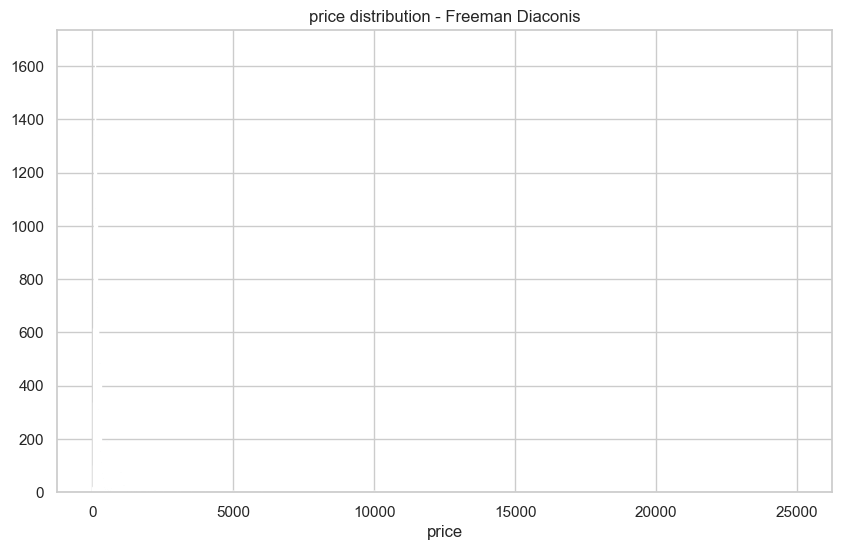

In [177]:
h = freeman_diaconis(all_listings.price)
plot_data = all_listings.price
variable_name = "price"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Yes - let's get rid of the 25000 listing and see if the histogram starts to make more sense

In [178]:
trimmed_listings = all_listings[all_listings.price < 1500]

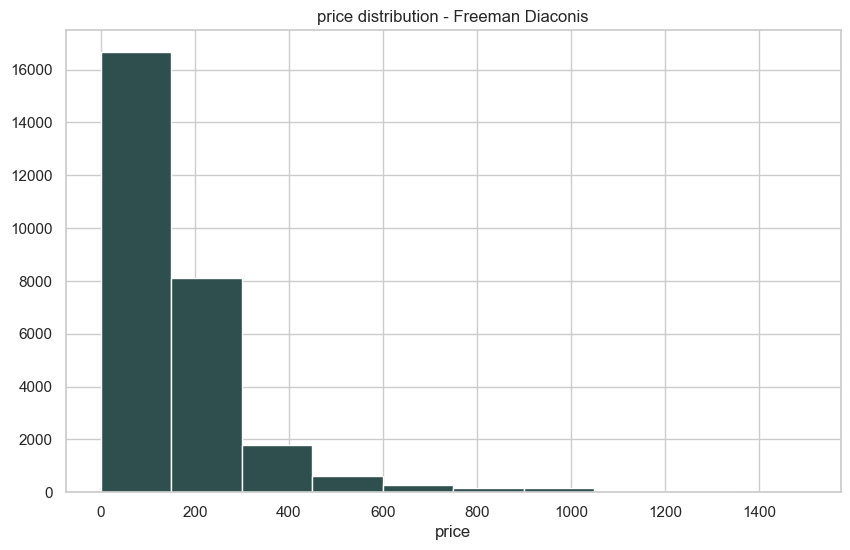

In [179]:
plot_data = trimmed_listings.price

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Removing listings below 1500 reveals a distribution with a very strong skew to the right. The distribution appears to be almost exponential which would not make much sense given our domain knowledge. Let's use Freeman Diaconis bins and limit the listings from 0-500

Freeman Diaconis:  7


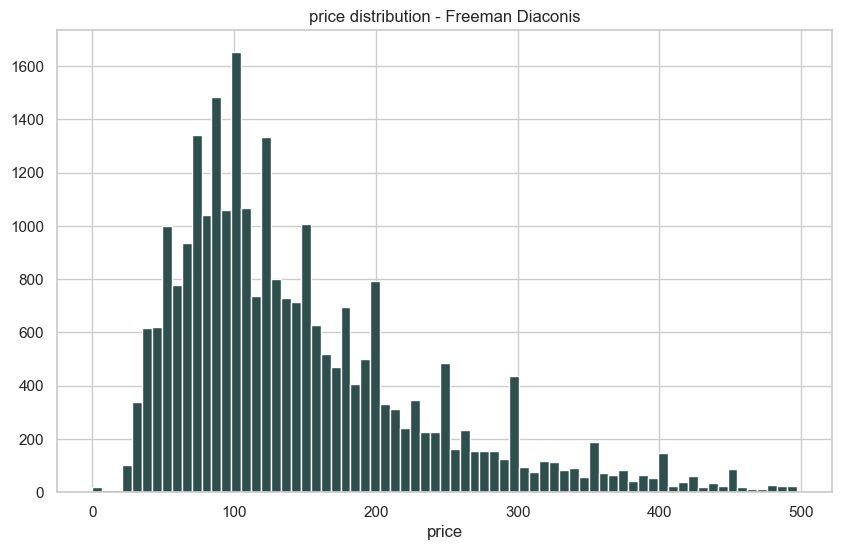

In [180]:
listings_below_500 = all_listings[all_listings.price < 500]

h = freeman_diaconis(listings_below_500.price)
plot_data = listings_below_500.price
variable_name = "price"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Looking at the above distribution, we see a that there is a strong skew to the right even when we remove all listings over 500 per night. This can be interpreted as the majority of AirBnBs having a nightly price that is between 85 and 200 per night but then increasingly expensive houses becomes less and less popular. 

Moving on to the single variable analysis of `neighborhoods`...

<a id="neighborhood"></a>
## Neighborhood

The neighborhood variable is the string name of the DMV neighborhood in which the AirBnB is located. The dataset description says that the AirBnBs in this dataset are all located within D.C. so we expect the neighborhood names to be all neighborhoods within the actual district. As for how many neighborhoods there will be, that depends on how granular the neighborhood boundaries are. It would make sense for AirBnB to default to some governmental agency to define the neighborhood boundaries because neighorhood boundaries are highly subjective and constantly changing in the colloquial sense. For that reason, I expect the number of neighborhoods to be somewhere between 20 and 40.

In [183]:
print(neighborhoods.neighbourhood)

0                  Brightwood Park, Crestwood, Petworth
1                         Brookland, Brentwood, Langdon
2                            Capitol Hill, Lincoln Park
3       Capitol View, Marshall Heights, Benning Heights
4        Cathedral Heights, McLean Gardens, Glover Park
5     Cleveland Park, Woodley Park, Massachusetts Av...
6     Colonial Village, Shepherd Park, North Portal ...
7     Columbia Heights, Mt. Pleasant, Pleasant Plain...
8      Congress Heights, Bellevue, Washington Highlands
9     Deanwood, Burrville, Grant Park, Lincoln Heigh...
10                             Douglas, Shipley Terrace
11    Downtown, Chinatown, Penn Quarters, Mount Vern...
12           Dupont Circle, Connecticut Avenue/K Street
13                         Eastland Gardens, Kenilworth
14    Edgewood, Bloomingdale, Truxton Circle, Eckington
15    Fairfax Village, Naylor Gardens, Hillcrest, Su...
16    Friendship Heights, American University Park, ...
17                      Georgetown, Burleith/Hil

There are 38 total neighbrohoods in this dataset. They appear to encompass multiple colloquially-known neighborhoods given that their names almost all consist of multiple names combined in a comma-separated list. They appear in alphabetical order and the index on right right column of the above print-out will correspond to some labels I use below.

The `neighborhoods` table also includes a `polygon` shape of the neighborhood using lat/lon points. Let's map those:

In [48]:
!pip install geopandas

distutils: /Applications/Utilities/anaconda3/include/python3.7m/UNKNOWN
sysconfig: /Applications/Utilities/anaconda3/include/python3.7m
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 1.0 MB 22 kB/s eta 0:00:013
     |████████████████████████████████| 26.5 MB 92 kB/s  eta 0:00:01
     |████████████████████████████████| 7.5 MB 489 kB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 311 kB/s eta 0:00:01
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
distutils: /Applications/Utilities/anaconda3/include/python3.7m/UNKNOWN
sysconfig: /Applications/Utilities/anaconda3/include/python3.7m
user = False
home = None
root = None
prefix = None
You should consider upgrading via the '/Applications/Utilities/anaconda3/bin/python -m pip install --upgrade pip' command.


In [184]:
import geopandas as gpd
from shapely.geometry import Polygon

p_list = []
for p in neighborhoods.coordinates:
  p_list.append(Polygon(p))

neighborhoods_gpd = gpd.GeoDataFrame(neighborhoods, crs='epsg:4326', geometry=p_list)       

neighborhoods_gpd['rep_point'] = neighborhoods_gpd['geometry'].apply(lambda x: x.representative_point().coords[:])
neighborhoods_gpd['rep_point'] = [coords[0] for coords in neighborhoods_gpd['rep_point']]

neighborhoods_gpd['alpha_index'] = list(range(1,len(neighborhoods_gpd.neighbourhood)+1))

neighborhoods_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighbourhood_group  0 non-null      object  
 1   neighbourhood        39 non-null     object  
 2   type_outer           39 non-null     object  
 3   feature_type         39 non-null     object  
 4   geometry_type        39 non-null     object  
 5   coordinates          39 non-null     object  
 6   geometry             39 non-null     geometry
 7   rep_point            39 non-null     object  
 8   alpha_index          39 non-null     int64   
dtypes: geometry(1), int64(1), object(7)
memory usage: 2.9+ KB


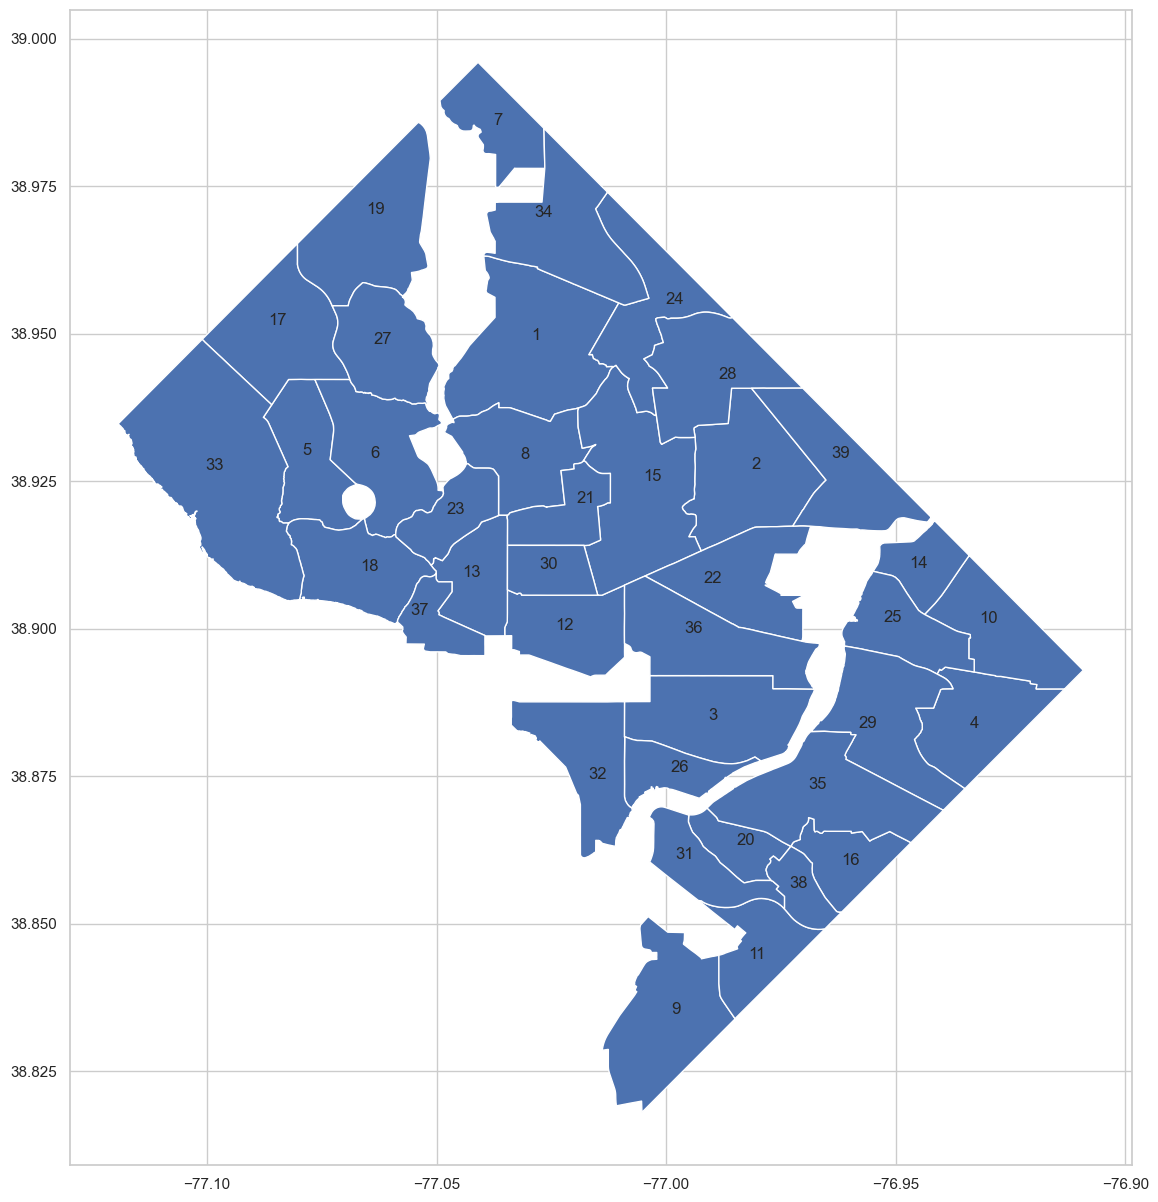

In [185]:
fig,ax = plt.subplots(figsize = (15,15))
neighborhoods_gpd.plot(ax=ax)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')

plt.show()

From the above map, we can see that all of these neighborhoods exist within the federal borders of the District of Columbia  (up until now, we were unsure if these neighborhoods bled into the surrounding DMV area). The polygons are of diverse shapes and sizes.  

The white spots in the map correspond to neighborhoods clusters that are not represented in the AirBnB dataset. These are:
* Observatory Circle (small white circle in the northwest quadrant). Houses the US Naval Observatory and the house of the US Vice President.
* Rock Creek Park (long thin cluster extending from the top of the diamond to cluster 23). A national park.
* Walter Reed (trapazoidal polygon missing between 7 and 34). A military hospital.
* Arboretum, Anacostia River (long, river-shaped polygon starting between 31 and 32 and ending between 14 and 39). A river and a federally run arboretum.
* National Mall, Potomac River (The polygon missing from the entire southwest quadrant of the diamond, spanning from 33 to 9 and taking the horizontal rectanglular chunk from between 12, 36, 3, and 32). The national mall of the US Capitol and a large river between DC and Virginia.
* Joint Base, Anacostia Boilings (the misisng polygon west of 9 bordering the Potomac and Anacostia). A Naval and Joint Armed Forces base.
* Saint Elizabeth's (the rectangular polygon missing between 31, 11, and 9). A hospital.

Source: https://opendata.dc.gov/datasets/neighborhood-clusters/explore?location=38.855725%2C-77.000257%2C11.77.

We now move on to single variable EDA on variables that deal with data about the *host* of the AirBnB.

In [192]:
latest_hosts_unique = latest_listings.drop_duplicates(subset='host_id')

## `host_since` <a id="host_since"></a>

This variable corresponds to the date on which the host became an AirBnB host. It is saved as a Pandas `datetime`. We can use this data to understand how many day/months/years each person has been a host. AirBnB is only about 14 years old so we expect the maximum number of years someone has been a host to be less than 14. Between 0 and 14 I expect most people to have been hosts between 0 and 7 years and fewer between 7 and 14 which would cause a skew to the right.

In [187]:
import datetime

In [198]:
timestamp = pd.Timestamp(datetime.datetime(2021, 10, 10))
res = timestamp.today()
latest_hosts_unique.days_host = (res - latest_hosts_unique.host_since) / np.timedelta64(1,'D')
latest_hosts_unique.years_host = (res - latest_hosts_unique.host_since) / np.timedelta64(1,'Y')
latest_hosts_unique.days_host

0        5118.715739
1        4374.715739
2        5102.715739
3        3870.715739
4        4248.715739
            ...     
10531     262.715739
10547    1640.715739
10549    1028.715739
10550    1555.715739
10554     325.715739
Name: host_since, Length: 5843, dtype: float64

In [196]:
latest_hosts_unique.days_host.describe()

count    5840.000000
mean     2503.553492
std       986.443234
min        83.713938
25%      2009.713938
50%      2578.713938
75%      3151.963938
max      5123.713938
Name: host_since, dtype: float64

In [199]:
latest_hosts_unique.years_host.describe()

count    5840.000000
mean        6.854502
std         2.700790
min         0.229206
25%         5.502415
50%         7.060284
75%         8.629789
max        14.028257
Name: host_since, dtype: float64

The minimum number of years is 0.23 years and the maximum is just over 14 which tracks. The mean is just under 7 years.

Freeman Diaconis:  0


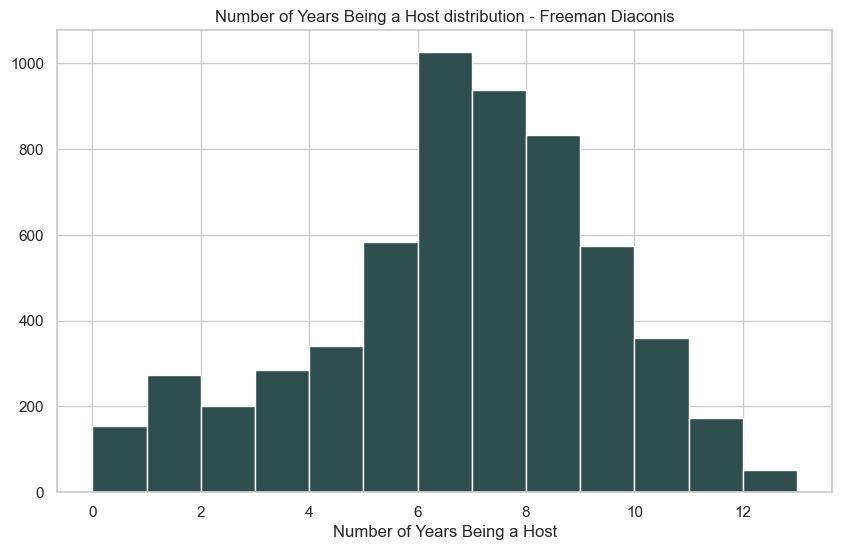

In [200]:
h = freeman_diaconis(latest_hosts_unique.years_host.dropna())
plot_data = latest_hosts_unique.years_host.dropna()
variable_name = "Number of Years Being a Host"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

This distribution is mostly symmetric with a slight skew to the left. The majority of the data is etween 6 and 9 years. Few hosts have been hosts for less than 4 years ore more than 10.5

## `host_location` <a id="host_location"></a>

This variable is a categorical string variable indicating where the host resides. I don't know if this data is self-reported or chosen from a selection. I would expect most hosts to live in D.C. because they own property within D.C.

In [107]:
latest_listings.host_location.value_counts(normalize=True)[:10]

Washington, DC                                     0.439045
Washington, District of Columbia, United States    0.227377
Houston, Texas, United States                      0.062631
US                                                 0.035714
New York, NY                                       0.031211
United States                                      0.012882
Arlington, VA                                      0.008065
Silver Spring, MD                                  0.007331
New York, New York, United States                  0.006075
Alexandria, Virginia, United States                0.005237
Name: host_location, dtype: float64

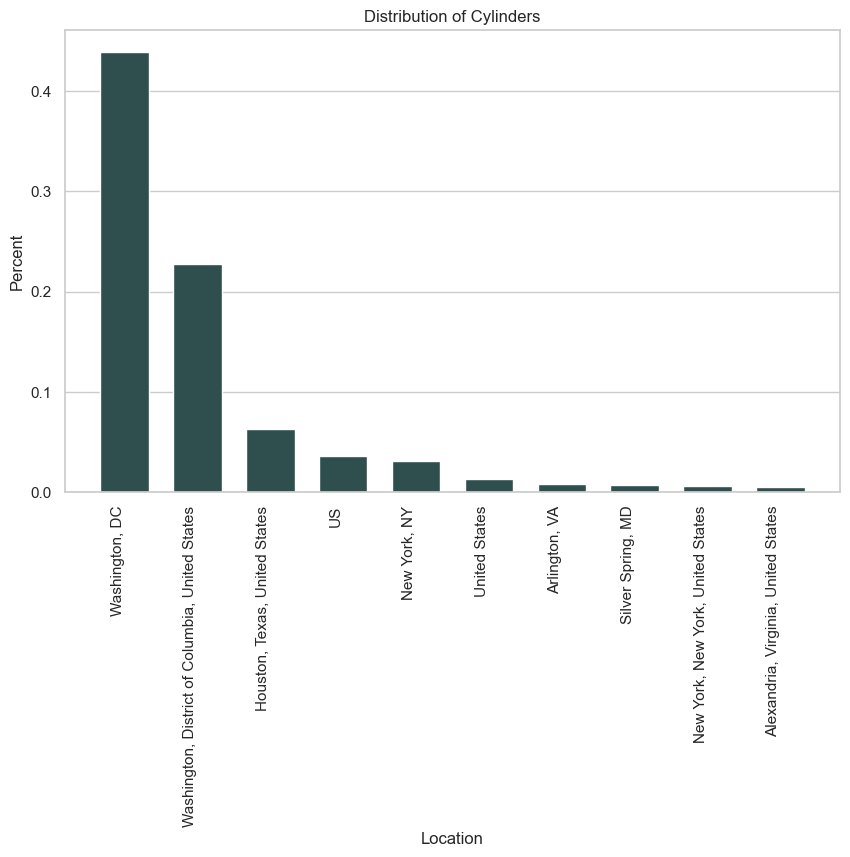

In [112]:
data = latest_listings.host_location.value_counts(normalize=True)[:10]
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_location.value_counts()[:10]).values()))))
axes.set_xticklabels(dict(latest_listings.host_location.value_counts()[:10]).keys())
axes.set_title( "Distribution of Cylinders")
axes.set_xlabel("Location")
axes.set_xticklabels(dict(latest_listings.host_location.value_counts()[:10]).keys(), rotation=90, ha='right')
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

This data is not very useful. There are overlapping and redundant categories - namely there is bboth a "Washington, District of Columbia, United States" AND a "Washington, DC" category. There is also a "US" and "United States" category which *might* mean these people live in D.C. or might mean anywhere else within the United States.

Regardless, the majority of hosts live within DC.

## `host_response_time` <a id="host_response_time"></a>

Host response time is the AirBnB autogenerated cateogorical variable assigned to each host based on their response time to customer messages. These categories include things like "within an hour" or "within a couple of days". I expect most hosts to respond "within a day" or "within a few hours" because there is an advantage in getting customer to trust/like you if you respond faster. 

In [114]:
latest_listings.host_response_time.value_counts()

within an hour        5525
N/A                   2946
within a few hours    1078
within a day           657
a few days or more     192
Name: host_response_time, dtype: int64

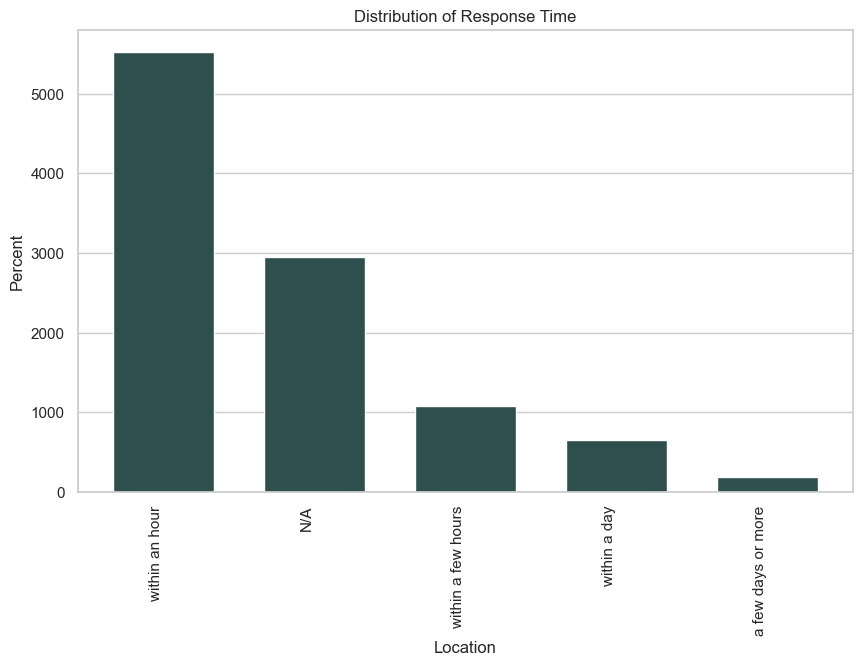

In [382]:
data = latest_listings.host_response_time.value_counts()
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_response_time.value_counts()).values()))))
axes.set_title( "Distribution of Response Time")
axes.set_xlabel("Location")
axes.set_xticklabels(dict(latest_listings.host_response_time.value_counts()).keys(), rotation=90, ha='right')
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

There is a sizable portion of hosts within the "N/A" category. That aside, the clear majority of remaining hosts respond within the hour with subsequent categories having a decreasing frequency in order of length of time to respond.

## `host_response_rate` <a id="host_response_rate"></a>

Host response rate is the percentage of messages from customers that hosts respond to at all, regardless of time. This will be on a range of 0-100. I expect the mean number to be greater than 90% because hosts have an incentive to respond to every message from a potential customer in order to gain their business and current customers to maintain a high rating. 

In [123]:
latest_listings['host_response_rate'] = latest_listings['host_response_rate'].replace('N/A',np.NaN)
latest_listings['host_response_rate'] = latest_listings['host_response_rate'].replace('%', '', regex=True).astype(float)

In [124]:
latest_listings['host_response_rate'].describe()

count    7452.000000
mean       95.040794
std        15.631311
min         0.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: host_response_rate, dtype: float64

As expected, the mean host response rate is 95%. The entire IQR is 100% meaning that the mean is getting skewed by outliers - probably a series of hosts with a response rate of 0.

Freeman Diaconis:  0


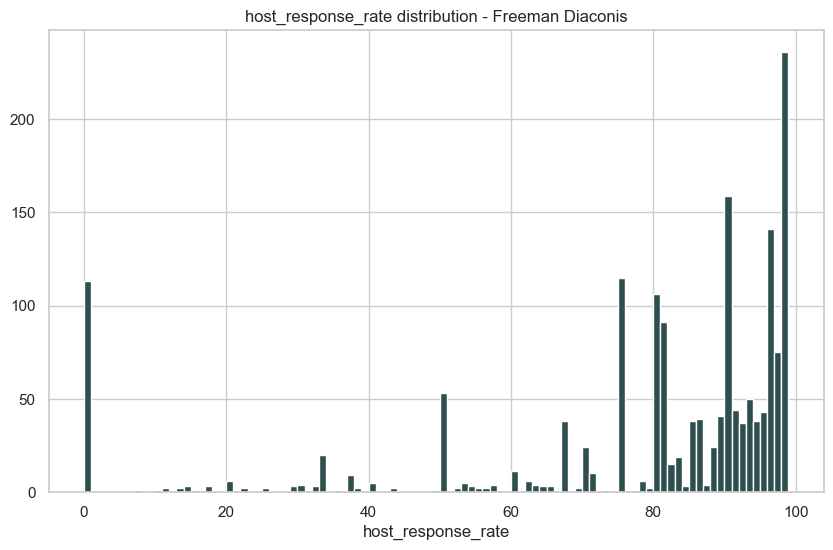

In [128]:
h = freeman_diaconis(latest_listings['host_response_rate'].dropna())
plot_data = latest_listings['host_response_rate'].dropna()
variable_name = "host_response_rate"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

The distribution is clearly skewed to the right. Almost ll the data is etween 80 and 100%. There is another mode at 0% which is presumably from rows within `listings` that have null values and/or hosts that are completely inactive on the website but do still have accounts as hosts.

## `host_acceptance_rate` <a id="host_acceptance_rate"></a>

Host acceptance rate is the rate of customer bids that this host accepts from 0-100. I expect this number to be high (>80%) because hosts have a monetary incentive to accept as many guests as possible throughout the year. I don't expect the IQR to be 100% like the last variable because hosts cannot say yes to everyone - especially for high-demand properties.

In [129]:
latest_listings['host_acceptance_rate'] = latest_listings['host_acceptance_rate'].replace('N/A',np.NaN)
latest_listings['host_acceptance_rate'] = latest_listings['host_acceptance_rate'].replace('%', '', regex=True).astype(float)

In [130]:
latest_listings['host_acceptance_rate'].describe()

count    8120.000000
mean       85.751108
std        24.362805
min         0.000000
25%        85.000000
50%        97.000000
75%       100.000000
max       100.000000
Name: host_acceptance_rate, dtype: float64

The mean acceptance rate is 85%. The median is 97% indicating that, once again, the mean acceptance rate is being skewed by a handful of low outliers - likely hosts with a zero acceptance rate.

Freeman Diaconis:  1


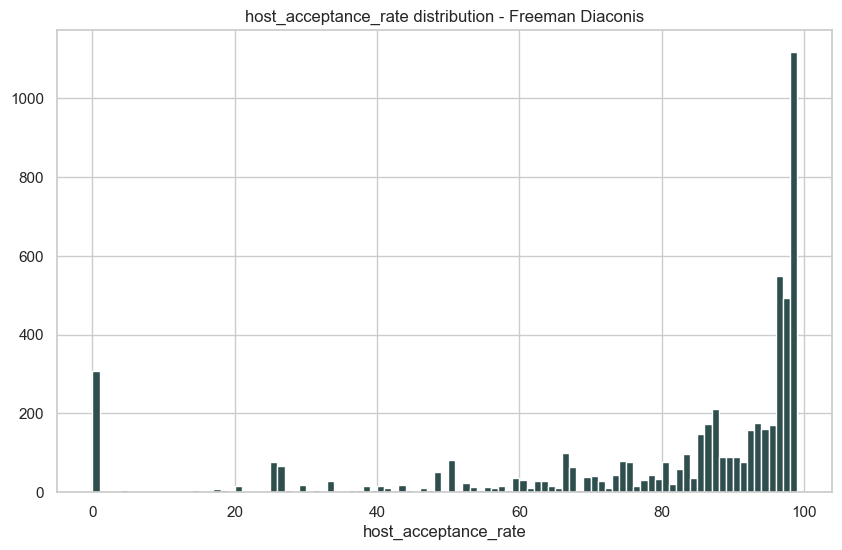

In [131]:
h = freeman_diaconis(latest_listings['host_acceptance_rate'].dropna())
plot_data = latest_listings['host_acceptance_rate'].dropna()
variable_name = "host_acceptance_rate"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

this distribution is highly skewed to the left once again. There are a handful of hosts with a 0% acceptance rate. This is likely from rows in `listings` that have all null values or from inactive hosts that still have desired property listings but never accept new guests.

## `host_is_superhost` <a id="host_is_superhost"></a>

This variable is a boolean variable indicating whether or not this host is a superhost. According to AirBnB, superhost status requires:
* Hostings at least 10 trips within the past year
* Having a response rate of at least 90%
* Having >80% of your trip ratings be 5 stars
* Not cancelling reserved reservations besides extenuating circumstances.

Based on past EDA and domain knowledge, these requirements are difficult to achieve. I expect there to be more non-superhosts than superhosts.

In [132]:
latest_listings.host_is_superhost.value_counts()

False    7950
True     2604
Name: host_is_superhost, dtype: int64

Only a quarter of hosts are superhosts.

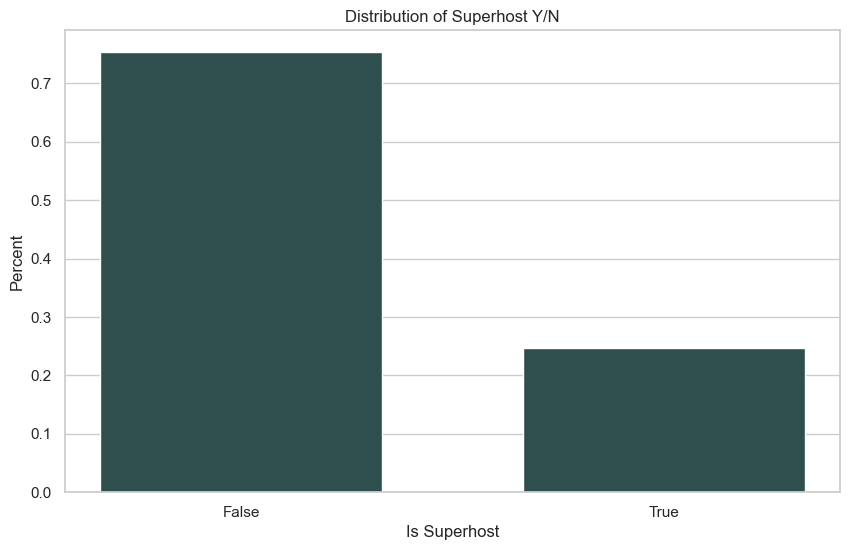

In [135]:
data = latest_listings.host_is_superhost.value_counts(normalize=True)
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_is_superhost.value_counts()).values()))))
axes.set_title( "Distribution of Superhost Y/N")
axes.set_xlabel("Is Superhost")
axes.set_xticklabels(dict(latest_listings.host_is_superhost.value_counts()).keys())
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

75% of hosts within the last quarter are not superhosts, whereas 25% of them are.

## `host_listings_count` <a id="host_listings_count"></a>

This variable counts the number of listings that this host has within AirBnB. I expect this number to range from 1 to 25 with most hosts only having between 1 and 3 properties. 

In [136]:
latest_listings['host_listings_count'].describe()

count    10398.000000
mean       165.797750
std        676.694138
min          0.000000
25%          1.000000
50%          2.000000
75%         10.000000
max       4057.000000
Name: host_listings_count, dtype: float64

There are a couple of clear outliers and/or impossibilities. There should not be any hosts in the AirBnB database with 0 listings. The maximum number being >4000 seems to be an extreme outlier given that the IQR is between 1 and 10 listings. The mean is being heavily skewed by these high outliers.

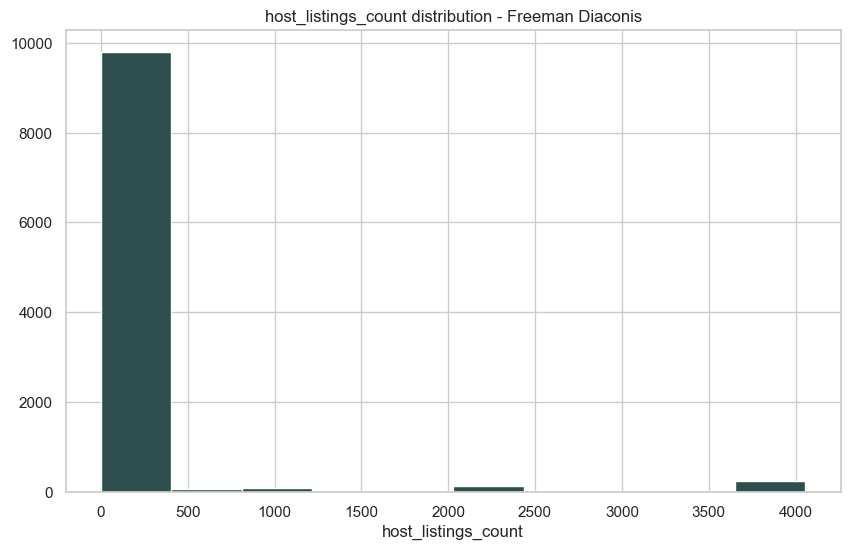

In [138]:
# h = freeman_diaconis(latest_listings['host_listings_count'].dropna())
# plot_data = latest_listings['host_listings_count'].dropna()
# variable_name = "host_listings_count"
# print("Freeman Diaconis: ", h)
# mn = int(plot_data.min())
# mx = int(plot_data.max())
# bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Clearly, most of the data is less than 500, and likely most of the data is less than 20. Let's chop off some of the very high values.

Freeman Diaconis:  0


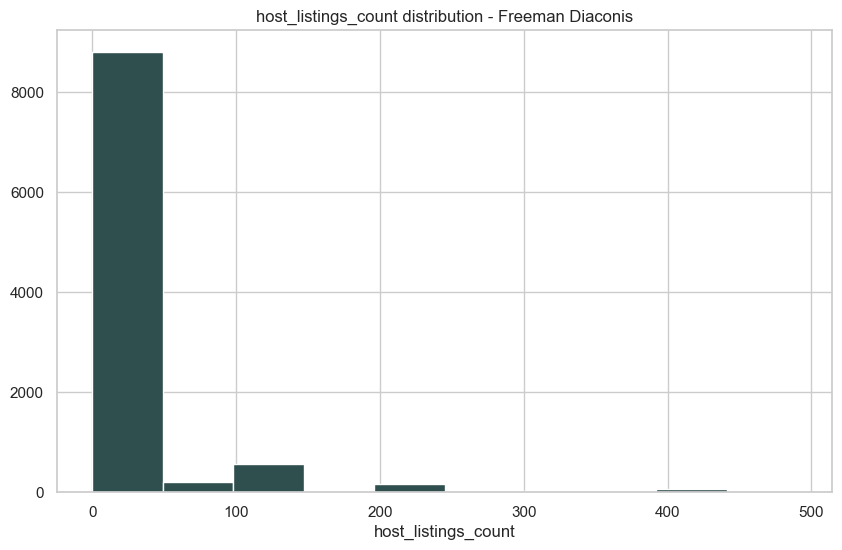

In [139]:
latest_listings.host_listings_count_under_500 = latest_listings.host_listings_count[latest_listings.host_listings_count < 500]
h = freeman_diaconis(latest_listings.host_listings_count_under_500.dropna())
plot_data = latest_listings.host_listings_count_under_500.dropna()
variable_name = "host_listings_count"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

There are a handful of hosts within the 50 to 250 range but clearly most of the data is less than 50.

Freeman Diaconis:  0


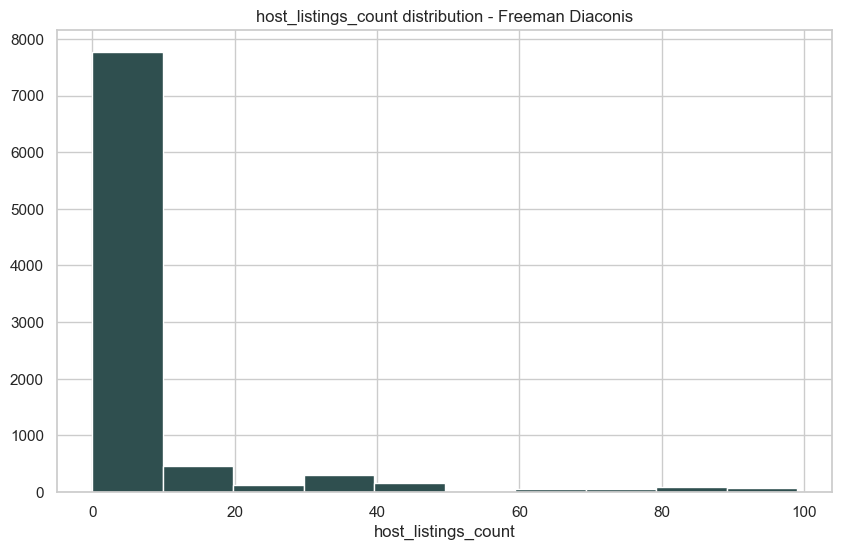

In [140]:
latest_listings.host_listings_count_under_100 = latest_listings.host_listings_count[latest_listings.host_listings_count < 100]
h = freeman_diaconis(latest_listings.host_listings_count_under_100.dropna())
plot_data = latest_listings.host_listings_count_under_100.dropna()
variable_name = "host_listings_count"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

More filtering...

Freeman Diaconis:  0


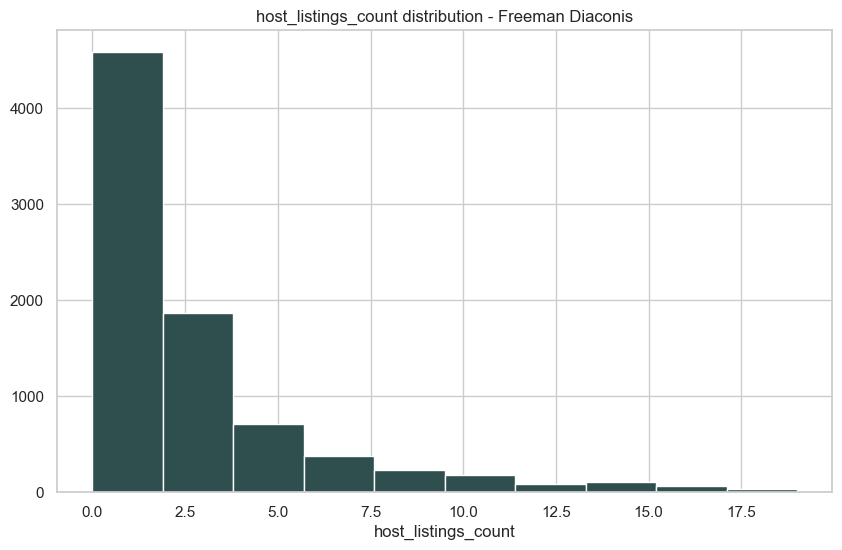

In [141]:
latest_listings.host_listings_count_under_20 = latest_listings.host_listings_count[latest_listings.host_listings_count < 20]
h = freeman_diaconis(latest_listings.host_listings_count_under_20.dropna())
plot_data = latest_listings.host_listings_count_under_20.dropna()
variable_name = "host_listings_count"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

When we look only at data between 0 and 20, we see that there is a clear exponential distribution of this variable. Most people have 1 listing. Some people have between 2 and 4. And then a handful of people have vetween 4 and 20 in a decreasing fashion.

## `host_verifications` <a id="host_verifications"></a>

This variable is a list of all the ways in which the host's identity has been verified. The popular avenues include things like "email" and "phone" via verification code but hosts also have the option of verifying via government IDs or any combination of things.

Because this variable is a list, I expect there to be hundres if not thousands of unique host_verification values. I expect "email" and "phone" to be the main avenues of verification because of its ease.

In [145]:
latest_listings.host_verifications.value_counts(normalize=True)[:10]

['email', 'phone']                                                                                    0.550095
['email', 'phone', 'work_email']                                                                      0.136080
['phone']                                                                                             0.051705
['email', 'phone', 'reviews', 'kba']                                                                  0.024716
['email', 'phone', 'reviews', 'jumio', 'government_id']                                               0.016004
None                                                                                                  0.015341
['email', 'phone', 'reviews']                                                                         0.014583
['email', 'phone', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']    0.010511
['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'government_id']                      0.010133
[

There were too many unique host_verification values to display so I displayed the 10 most common ones. ['email', 'phone'] were the most common at 55%. The second most common was just ['phone']. After that, no combination of host_verification (though all including 'email' and 'phone' except for None) make up more than ~5% of the hosts.

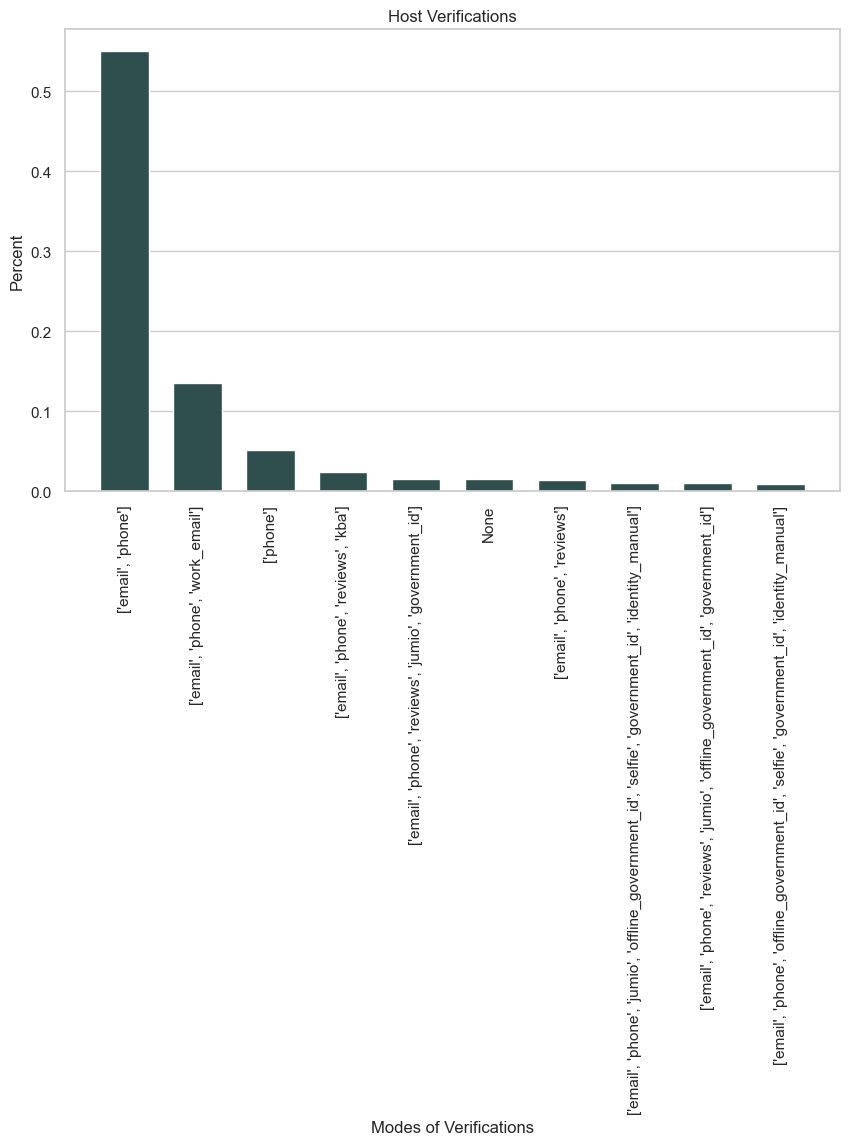

In [155]:
data = latest_listings.host_verifications.value_counts(normalize=True)[:10]
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_verifications.value_counts(normalize=True)[:10]).values()))))
axes.set_title( "Host Verifications")
axes.set_xlabel("Modes of Verifications")
axes.set_xticklabels(dict(latest_listings.host_verifications.value_counts(normalize=True)[:10]).keys(),rotation=90)
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

This chart shows the clear majority of host_verification being both email and phone.

## `host_has_profile_pic` <a id="host_has_profile_pic"></a>

This is a boolean variable indicating whether or not the host has a profile picture. According to AirBnB, all hosts are required to have a profile picture so I expect this variable to be almost 100% yes. Although there are null values in this dataset or junk rows that may present as "no"s.

In [147]:
latest_listings.host_has_profile_pic.value_counts()

True     10325
False       73
Name: host_has_profile_pic, dtype: int64

As expected, almost all hosts have a profile picture.

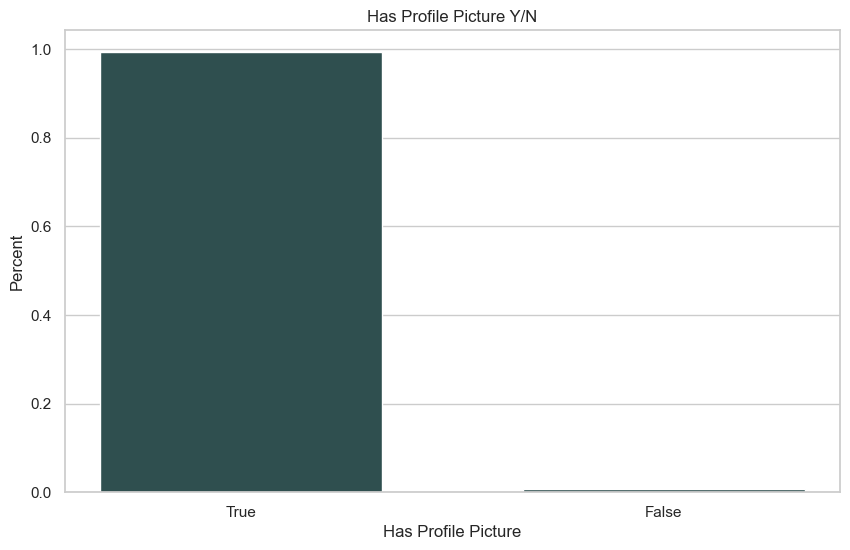

In [154]:
data = latest_listings.host_has_profile_pic.value_counts(normalize=True)
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_has_profile_pic.value_counts()).values()))))
axes.set_title( "Has Profile Picture Y/N")
axes.set_xlabel("Has Profile Picture")
axes.set_xticklabels(dict(latest_listings.host_has_profile_pic.value_counts()).keys())
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

Almost 100% of hosts have a profile picture and only 73 do not.

## `host_identity_verified` <a id="host_identity_verified"></a>

This variable is another boolean indicating whether the host's identity has been verified. AirBnB's process for host identification involves hosts providing their name, date of birth, or government ID. 

I would expect a clear majority of hosts to have their identity verified because they have an incentive to build trust with potential customers because that would ostensibly make customers more likely to book a listing with them.

In [150]:
latest_listings.host_identity_verified.value_counts()

True     8675
False    1723
Name: host_identity_verified, dtype: int64

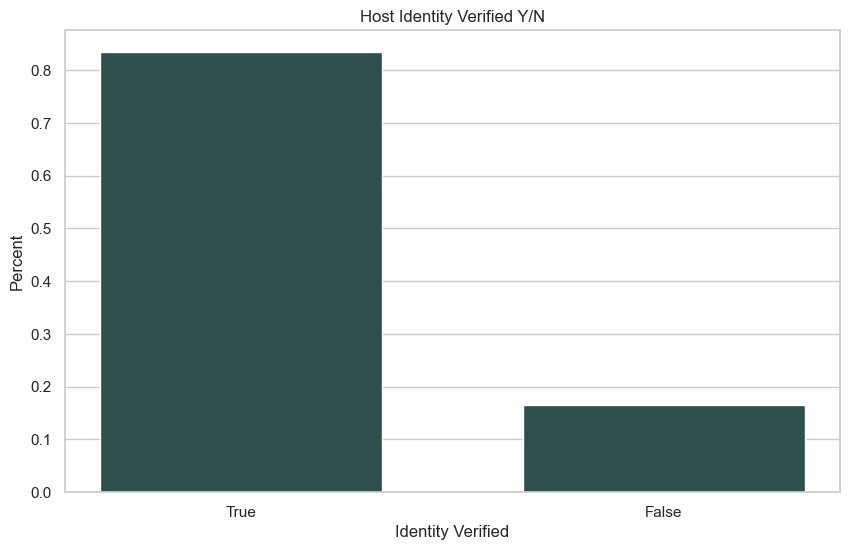

In [153]:
data = latest_listings.host_identity_verified.value_counts(normalize=True)
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_identity_verified.value_counts()).values()))))
axes.set_title( "Host Identity Verified Y/N")
axes.set_xlabel("Identity Verified")
axes.set_xticklabels(dict(latest_listings.host_identity_verified.value_counts()).keys())
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

Almost 85% of hosts have had their identity verified and just over 15% of hosts have not - as expected.

# Pairwise EDA - Target Variable: price <a id="pairwise_eda_price"></a>

Let's look at the pairwise analysis of `neighborhood` and `price`. I expect AirBnB price to track general rent cost of the D.C. areas. Neighborhoods with higher rent will have a higher nightly AirBnB price on average and the reverse would be true for areas with low rent. From general domain knowledge about Washington D.C., I know that the downtown area and the Northwest quadrant have higher rents on average than the Northeast and Southeast quadrant. Therefore I expect AirBnB nightly prices to be higher on average in the downtown area and the Northwest quadrant. 

One thing we will need to be mindful of in doing this analysis is the comparison of *counts* of AirBnB listings in each neighborhood cluster. Some clusters might have a high density of AirBnBs and others will have much fewer. Let's get the counts in tabular form as well as plotting them on the D.C. map. First, we must remove duplicate listings.

In [68]:
# Code from Lab 5 Solution
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

In [202]:
# Code from Module 5
def classify_correlation(r):
    r = abs(r)
    if r < 0.16:
        return "very weak"
    if r < 0.29:
        return "weak"
    if r < 0.49:
        return "low"
    if r < 0.69:
        return "moderate"
    if r < 0.89:
        return "strong"
    return "very strong"

In [203]:
# Code from Module 5
def correlation(data, x, y):
    print("Correlation coefficients:")
    r = stats.pearsonr(data[x], data[y])[0]
    print( "r   =", r, f"({classify_correlation(r)})")
    rho = stats.spearmanr(data[x], data[y])[0]
    print( "rho =", rho, f"({classify_correlation(rho)})")

In [204]:
# Code from Module 5
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):

    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)

    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)

    plt.show()
    plt.close()

In [209]:
# Code from Module 5
def restyle_boxplot(patch):
    ## change color and linewidth of the whiskers
    for whisker in patch['whiskers']:
        whisker.set(color='#000000', linewidth=1)

    ## change color and linewidth of the caps
    for cap in patch['caps']:
        cap.set(color='#000000', linewidth=1)

    ## change color and linewidth of the medians
    for median in patch['medians']:
        median.set(color='#000000', linewidth=2)

    ## change the style of fliers and their fill
    for flier in patch['fliers']:
        flier.set(marker='o', color='#000000', alpha=0.2)

    for box in patch["boxes"]:
        box.set( facecolor='#FFFFFF', alpha=0.5)

In [302]:
# Code from Module 5
def multiboxplot(data, numeric, categorical, skip_data_points=True):
    figure = plt.figure(figsize=(30, 6))

    axes = figure.add_subplot(1, 1, 1)

    grouped = data.groupby(categorical)
    labels = pd.unique(data[categorical].values)
    labels.sort()
    grouped_data = [grouped[numeric].get_group( k) for k in labels]
    patch = axes.boxplot( grouped_data, labels=labels, patch_artist=True, zorder=1)
    restyle_boxplot( patch)

    if not skip_data_points:
        for i, k in enumerate(labels):
            subdata = grouped[numeric].get_group( k)
            x = np.random.normal(i + 1, 0.01, size=len(subdata))
            axes.plot(x, subdata, 'o', alpha=0.4, color="DimGray", zorder=2)

    axes.set_xlabel(categorical)
    axes.set_xticklabels(labels, rotation=90, ha='right')
    axes.set_ylabel(numeric)
    axes.set_title("Distribution of {0} by {1}".format(numeric, categorical))

    plt.show()
    plt.close()

## `neighborhood` vs. `price` <a id="neighborhood_vs_price"></a>

We want to look at the interaction between neighborhood and price. Just like non-rental, non-hospitality real estate, AirBnB nightly price will vary by neighborhood. Nicer neighborhoods will generally have more expensive AirBnBs whereas poorer neighborhoods will generally have cheaper AirBnBs. 

Other factors that contribute to the correlation between neighborhood and price is the amenity makeup of a neighborhood. Neighborhoods with more access to amenities and attractions will have more expensive AirBnBs. For this reason, I suspect that neighborhoods near the central business district (downtown) will have more expensive AirBnBs.

For the remainder of this analysis we will use only the latest listings from the most recent quarter.

In [63]:
latest_listings = con.execute("select * from latest_listings;").df()
latest_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10560 entries, 0 to 10559
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            10560 non-null  int64         
 1   listing_url                                   10560 non-null  object        
 2   scrape_id                                     10560 non-null  int64         
 3   last_scraped                                  10560 non-null  datetime64[ns]
 4   name                                          10559 non-null  object        
 5   description                                   10416 non-null  object        
 6   neighborhood_overview                         6559 non-null   object        
 7   picture_url                                   10560 non-null  object        
 8   host_id                                       10560 non-null  int3

In [65]:
latest_listings_gdf = gpd.GeoDataFrame(
    latest_listings, geometry=gpd.points_from_xy(latest_listings.longitude, latest_listings.latitude))

Let's look at where the AirBnBs are on the neighborhood map.

In [66]:
type(latest_listings_gdf.geometry)

geopandas.geoseries.GeoSeries

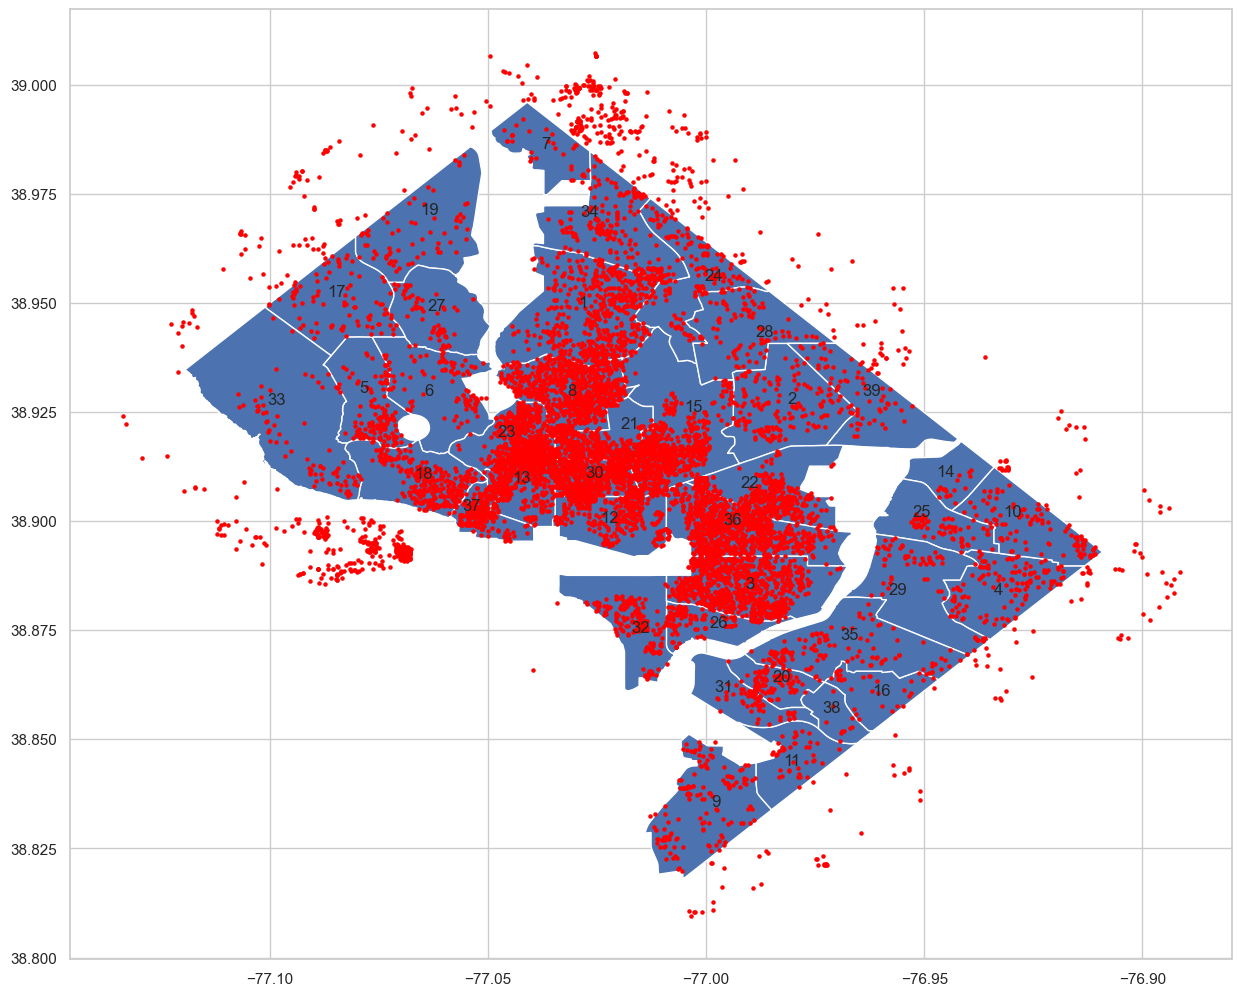

In [67]:
fig,ax = plt.subplots(figsize = (15,15))
base = neighborhoods_gpd.plot(ax=ax)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')
    
latest_listings_gdf.geometry.plot(ax=base, marker='o', color='red', markersize=5);
    
plt.show()

It turns out there *are* listings that exist outside of the DC borders. There are listings in the Arlington are of Virginia and various parts of Maryland. The listing densities of each neighbrhood cluster vary immensely. The clusters close to the downtown/National Mall area have the highest density of AirBnBs. The density becomes smaller the further out you go from downtown. Let's look at the densities in tabular form:

In [74]:
describe_by_category(latest_listings, "price", "neighbourhood_cleansed", transpose=True)

neighbourhood_cleansed  Brightwood Park, Crestwood, Petworth  \
count                                             518.000000   
mean                                              142.733591   
std                                               161.809158   
min                                                20.000000   
25%                                                69.000000   
50%                                                95.000000   
75%                                               150.000000   
max                                              1500.000000   

neighbourhood_cleansed  Brookland, Brentwood, Langdon  \
count                                      152.000000   
mean                                       130.921053   
std                                        107.605087   
min                                         29.000000   
25%                                         70.000000   
50%                                         99.000000   
75%                     

This data is pretty hard to consume but we can see a stark difference in the `count` of AirBnBs per neighborhood cluster. Let's plot the average price for each neighborhood using box plots to get a better feel for the comparative price

In [77]:
latest_listings_below_1500 =  latest_listings[latest_listings.price < 1500]

In [82]:
latest_listings_below_500 =  latest_listings[latest_listings.price < 500]

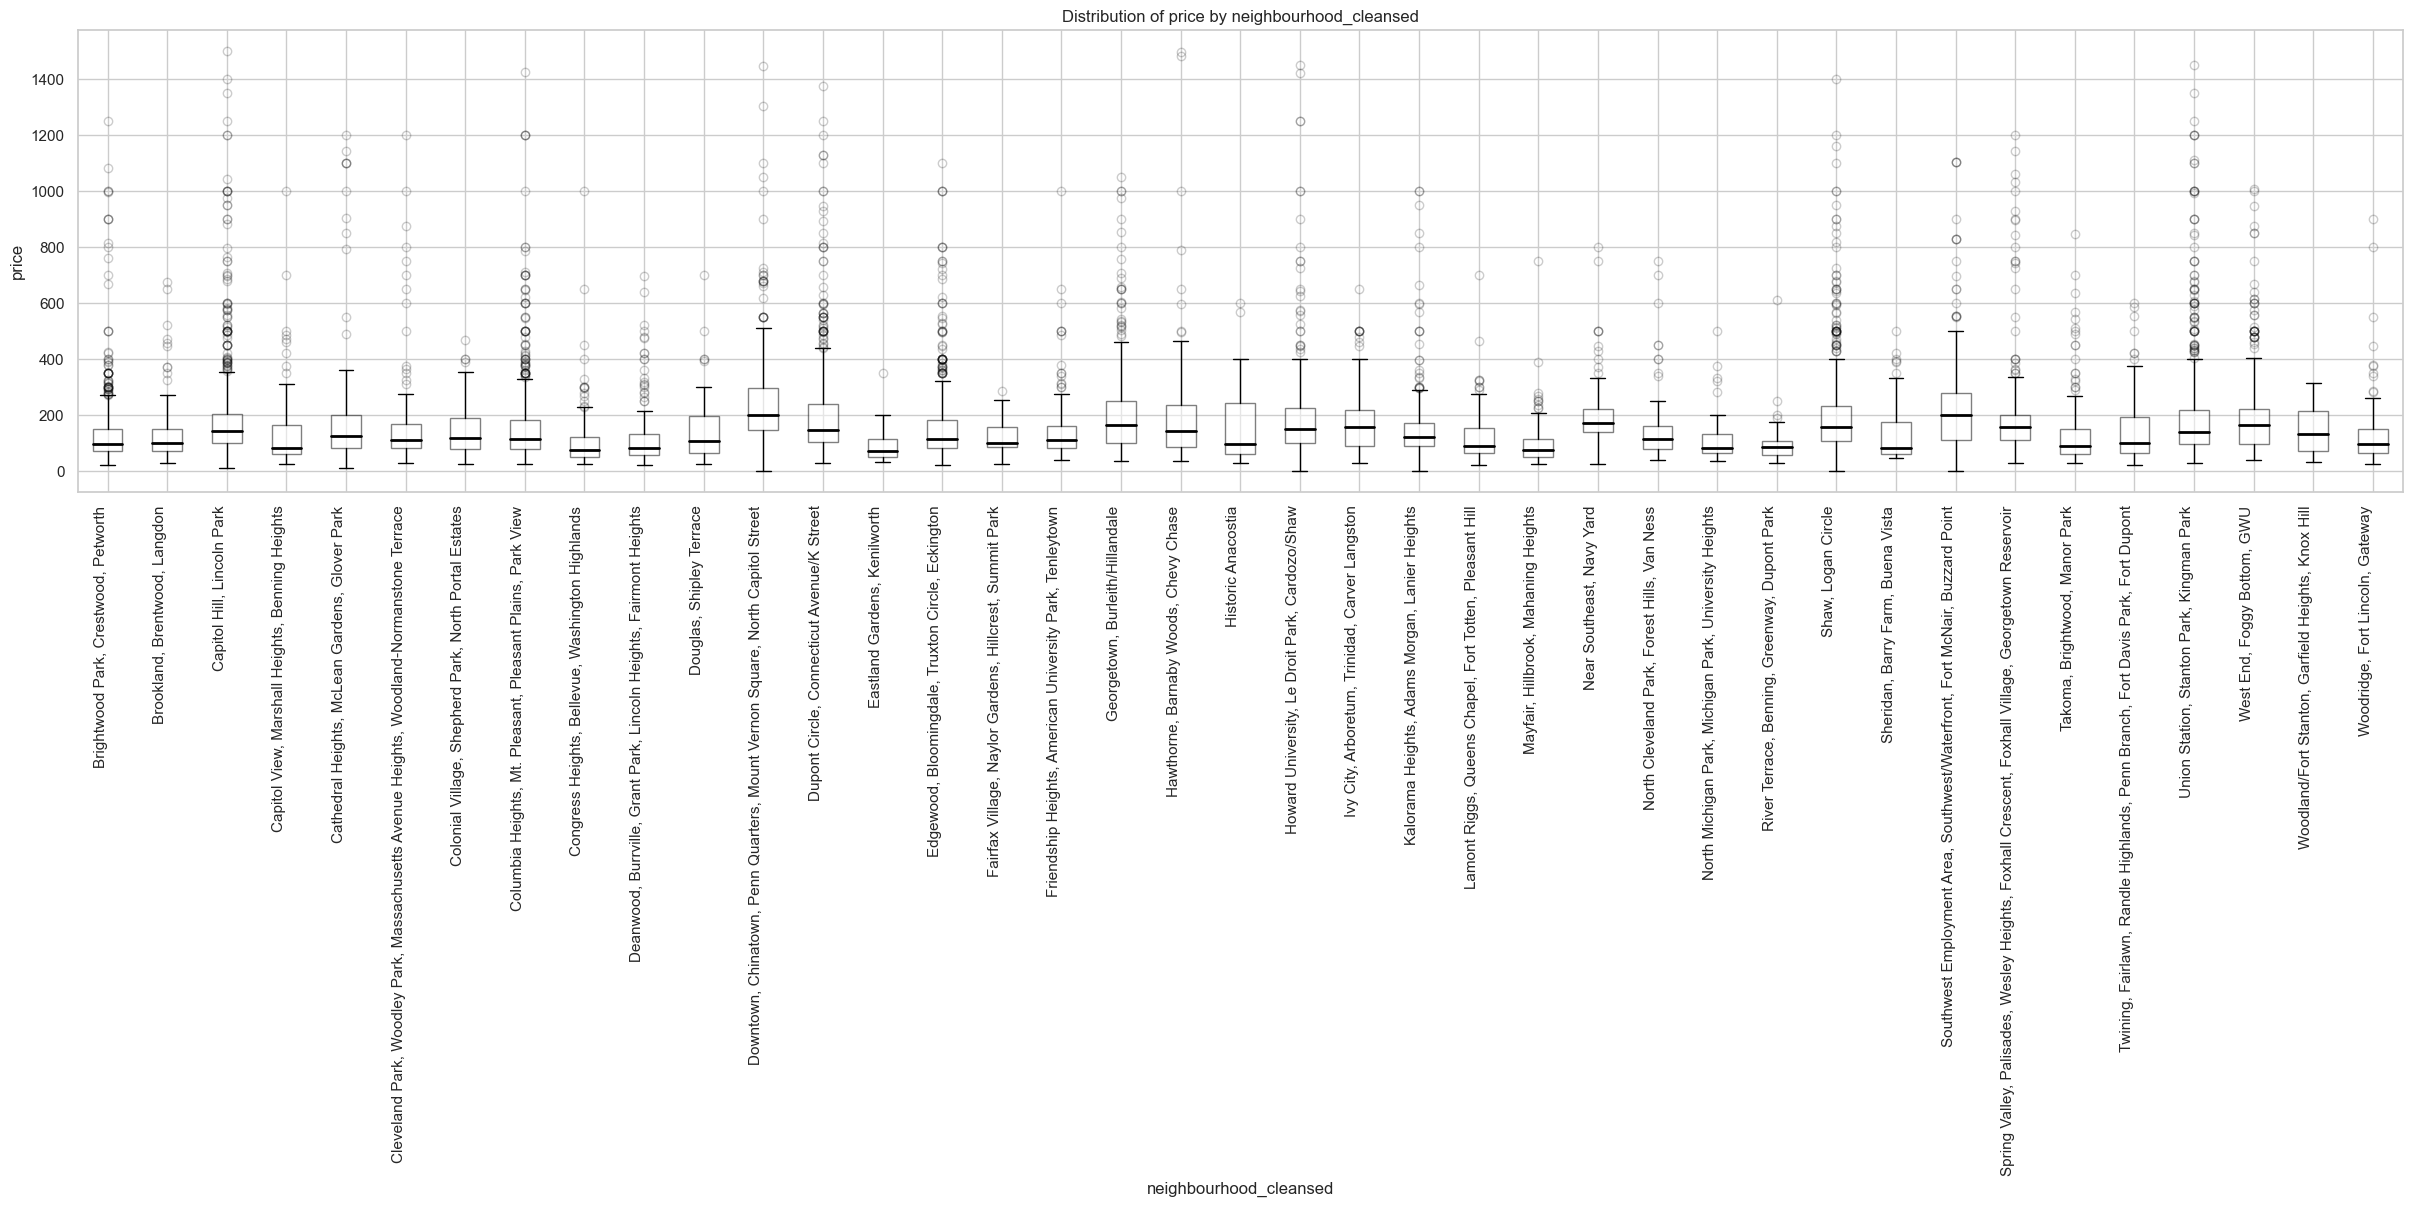

In [78]:
multiboxplot(latest_listings_below_1500, "price", "neighbourhood_cleansed")

From this plot, we can see that no neighborhood has a median nightly cost greater than ~200 USD. Some notably expensive neighborhoods include the Downtown Chinatown Penn Quarters are, Shaw Logan Circle, Georgetown, the Southwest Emplyment Area, Union Station, and West End. From my own experience living in D.C., all of these areas are near downtown, have good amenities, and are nicer neighborhoods than most.

I am now going to plot a heatmap of the average price of AirBnBs be neighborhood for (1) listings below 500 USD, (2) listings below 1500 USD, and (3) all listings.

### Price by neighborhood (only listings below 500 USD)

In [311]:
grouped = latest_listings_below_500.groupby("neighbourhood_cleansed")
labels = pd.unique(latest_listings_below_500["neighbourhood_cleansed"].values)
labels.sort()
grouped_data = [grouped["price"].get_group( k) for k in labels]
grouped_y = grouped['price'].describe()
avg_price_per_neighborhood = list(grouped_y.iloc[:, 1])
neighborhoods_gpd['avg_price'] = avg_price_per_neighborhood

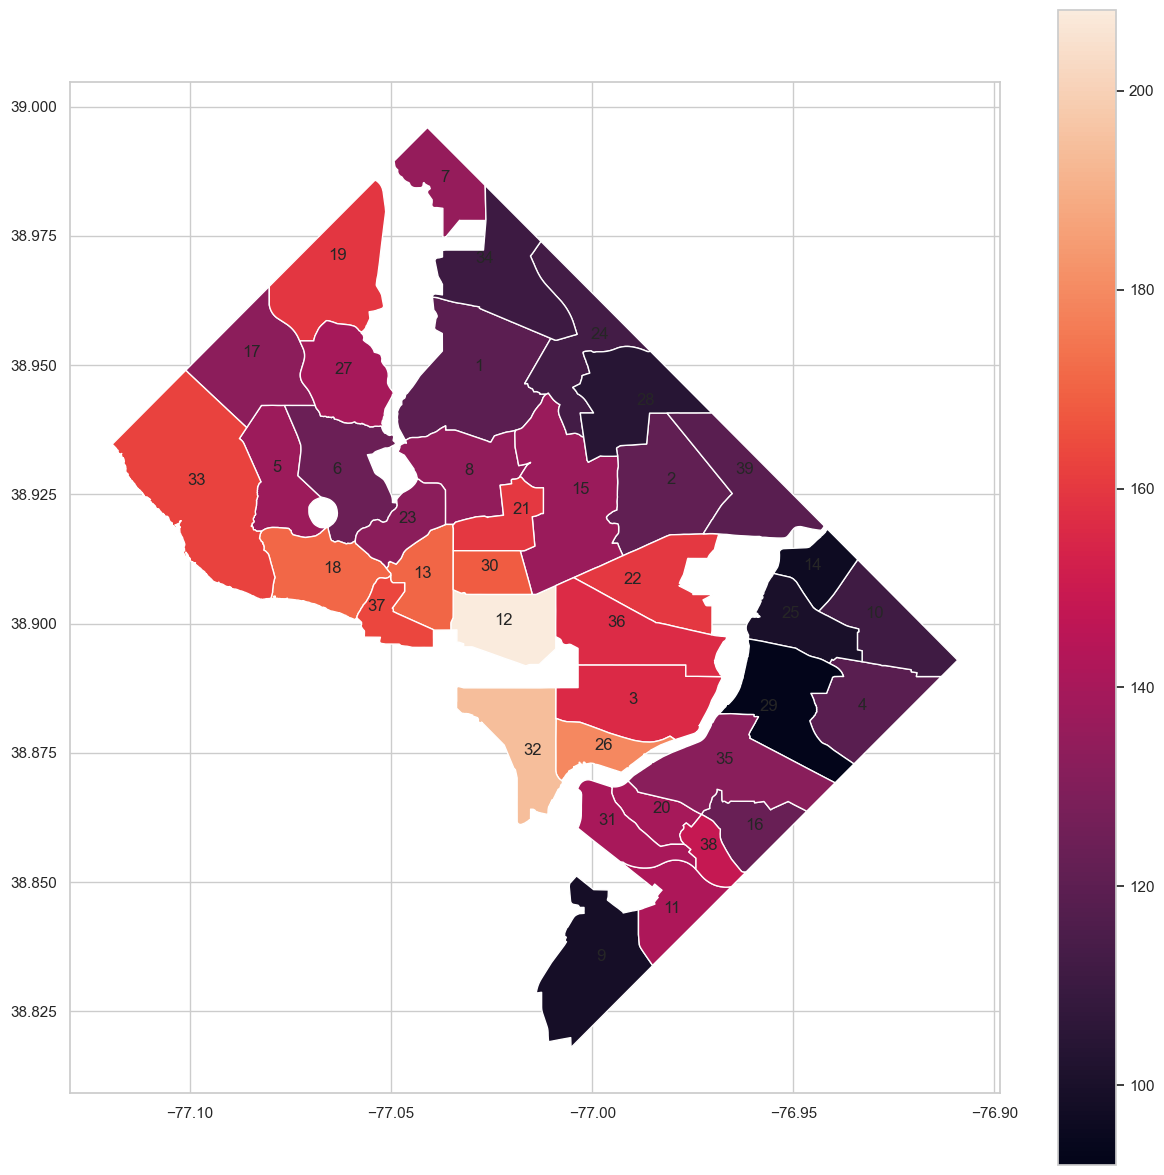

In [312]:
fig,ax = plt.subplots(figsize = (15,15))
base = neighborhoods_gpd.plot(ax=ax, column="avg_price",legend=True)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')

### Price by neighborhood (only listings below 1500 USD)

In [313]:
grouped = latest_listings_below_1500.groupby("neighbourhood_cleansed")
labels = pd.unique(latest_listings_below_1500["neighbourhood_cleansed"].values)
labels.sort()
grouped_data = [grouped["price"].get_group( k) for k in labels]
grouped_y = grouped['price'].describe()
avg_price_per_neighborhood = list(grouped_y.iloc[:, 1])
neighborhoods_gpd['avg_price'] = avg_price_per_neighborhood

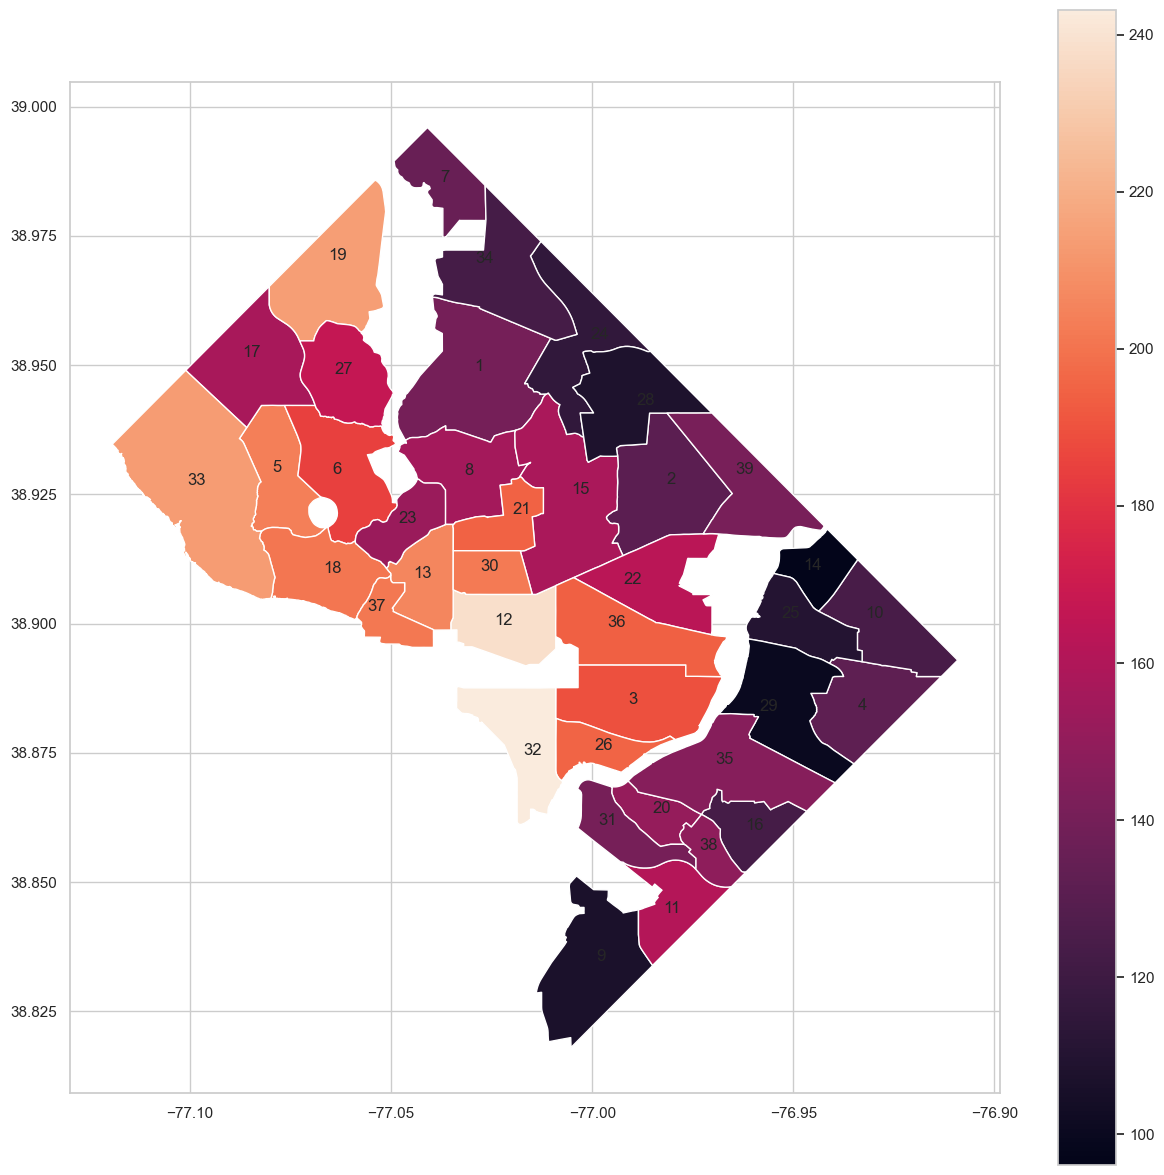

In [314]:
fig,ax = plt.subplots(figsize = (15,15))
base = neighborhoods_gpd.plot(ax=ax, column="avg_price",legend=True)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')

### Price by neighborhood (all listings)

In [315]:
grouped = latest_listings.groupby("neighbourhood_cleansed")
labels = pd.unique(latest_listings["neighbourhood_cleansed"].values)
labels.sort()
grouped_data = [grouped["price"].get_group( k) for k in labels]
grouped_y = grouped['price'].describe()
avg_price_per_neighborhood = list(grouped_y.iloc[:, 1])
neighborhoods_gpd['avg_price'] = avg_price_per_neighborhood

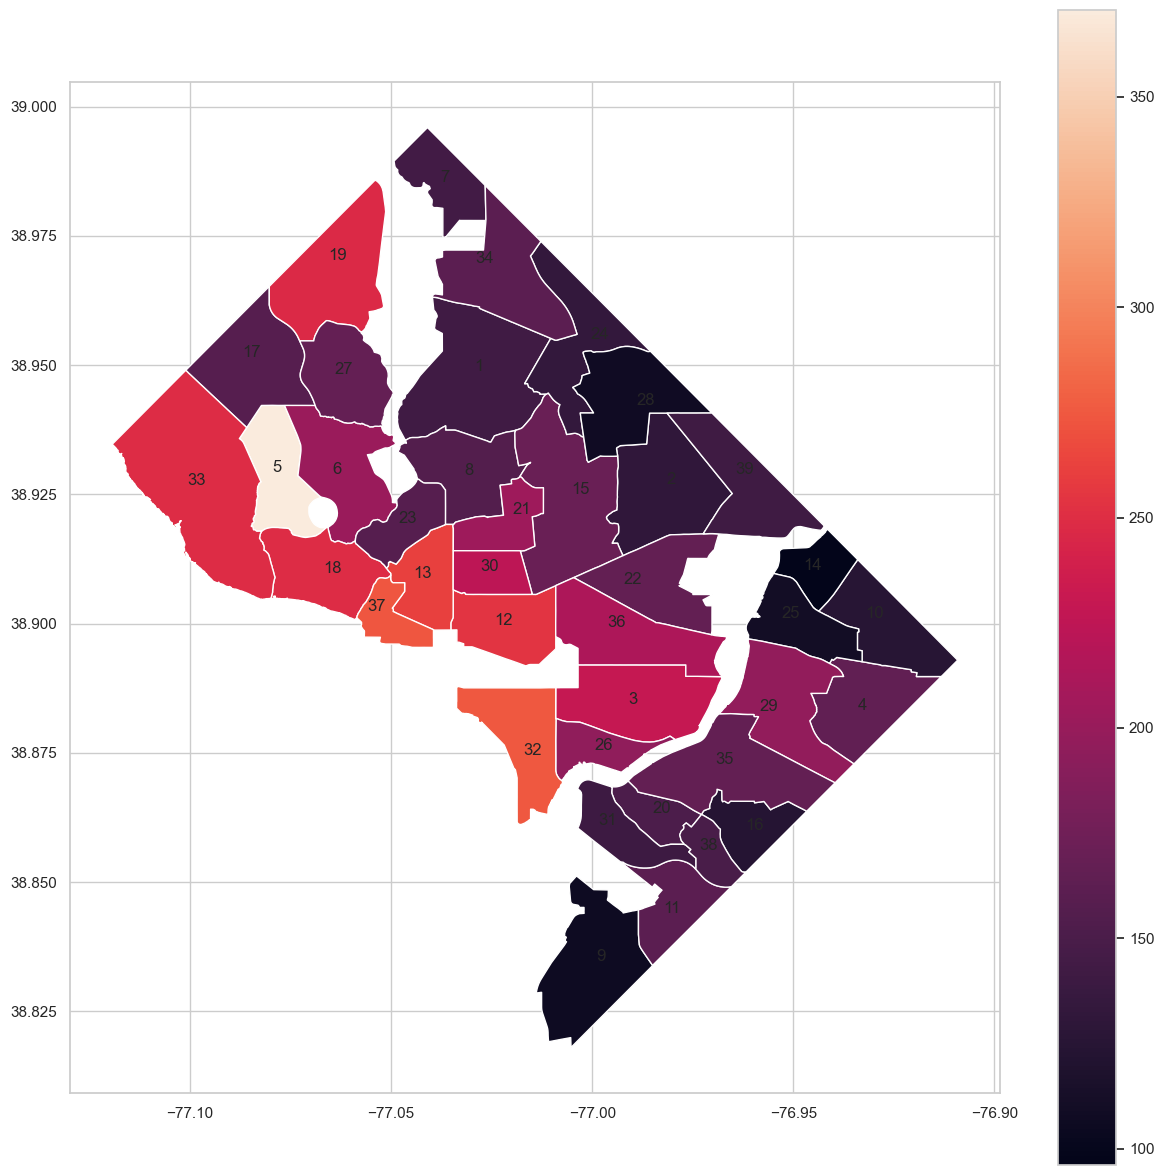

In [316]:
fig,ax = plt.subplots(figsize = (15,15))
base = neighborhoods_gpd.plot(ax=ax, column="avg_price",legend=True)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')

Clearly, the outliers in the `all_listings` table skew the coloring of the map. However, all maps align with what was predicted in that areas near downtown and/or the NW quadrant of the city (especially near the Potomac) are most expensive. Areas in the NE and SE quadrant, especially areas further away radially from Downtown are less expensive.

In [214]:
latest_listings["years_host"] = (res - latest_listings.host_since) / np.timedelta64(1,'Y')

In [217]:
latest_listings['price'].isnull().values.any()

False

## `host_since` vs `price` <a id="host_since_vs_price"></a>

We are now going to look at the relationship between how long someone has been a host and the price of their listings. I don't expect there to be any kind of strong correlation between the two.

In [224]:
latest_listings_non_null_host_since = latest_listings[latest_listings["years_host"].notnull()]

In [225]:
correlation(latest_listings_non_null_host_since, "price", "years_host")

Correlation coefficients:
r   = -0.0032471026963352473 (very weak)
rho = -0.08698568268122552 (very weak)


As I expected, there is almost zero correlation. Let's look at the scatterplot

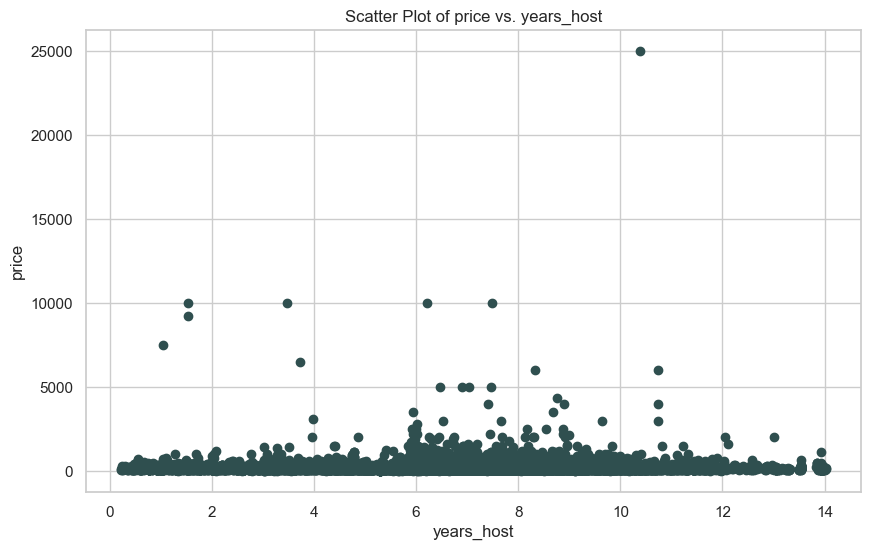

In [226]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_since.years_host, latest_listings_non_null_host_since.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("years_host")
axes.set_title("Scatter Plot of price vs. years_host")

plt.show()
plt.close()

This plot shows the average price is almost a straight line across all years being a host. The outliers making it hard to see detail. Let's zoom in:

In [228]:
latest_listings_below_500["years_host"] = (res - latest_listings_below_500.host_since) / np.timedelta64(1,'Y')

In [229]:
latest_listings_non_null_host_since_below_500 = latest_listings_below_500[latest_listings_below_500["years_host"].notnull()]

In [230]:
correlation(latest_listings_non_null_host_since_below_500, "price", "years_host")

Correlation coefficients:
r   = -0.10565400632052657 (very weak)
rho = -0.11097828442186954 (very weak)


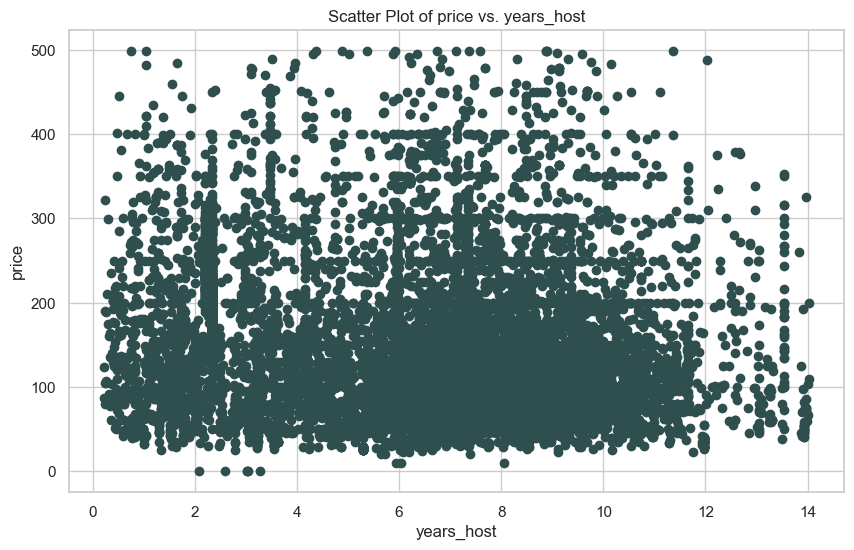

In [231]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_since_below_500.years_host, latest_listings_non_null_host_since_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("years_host")
axes.set_title("Scatter Plot of price vs. years_host")

plt.show()
plt.close()

Even when we zoom in, there is clearly no correlation between year_host and price.

## `host_location` vs `price` <a id="host_location_vs_price"></a>

We are not going to investigate this relationship because the data is ambiguous in category. There are several categories meaning the same thing like "DC" and "Washington DC" or "United States" and "US" all being separate categories.

## `host_response_time` vs `price` <a id="host_response_time_vs_price"></a>

I don't expect there to be a direct, causal relationship between these two variables. However, higher host response times likely correspond to a higher rating and overall stay experience which would in turn give the host leverage to raise the price of their AirBnB so I expect the relationship to be a slightly positive correlation.

In [240]:
describe_by_category(latest_listings_below_500, "price", "host_response_time", transpose=True)

host_response_time          N/A  a few days or more  within a day  \
count               2641.000000          182.000000    641.000000   
mean                 137.946611          124.197802    134.978159   
std                   94.925205           82.010068     81.423830   
min                    0.000000           25.000000     10.000000   
25%                   75.000000           65.000000     77.000000   
50%                  105.000000          100.000000    110.000000   
75%                  174.000000          150.000000    170.000000   
max                  499.000000          485.000000    499.000000   

host_response_time  within a few hours  within an hour  
count                      1047.000000     5344.000000  
mean                        117.108883      162.850299  
std                          82.213391       88.979790  
min                          22.000000        0.000000  
25%                          57.000000       95.000000  
50%                          95.0000

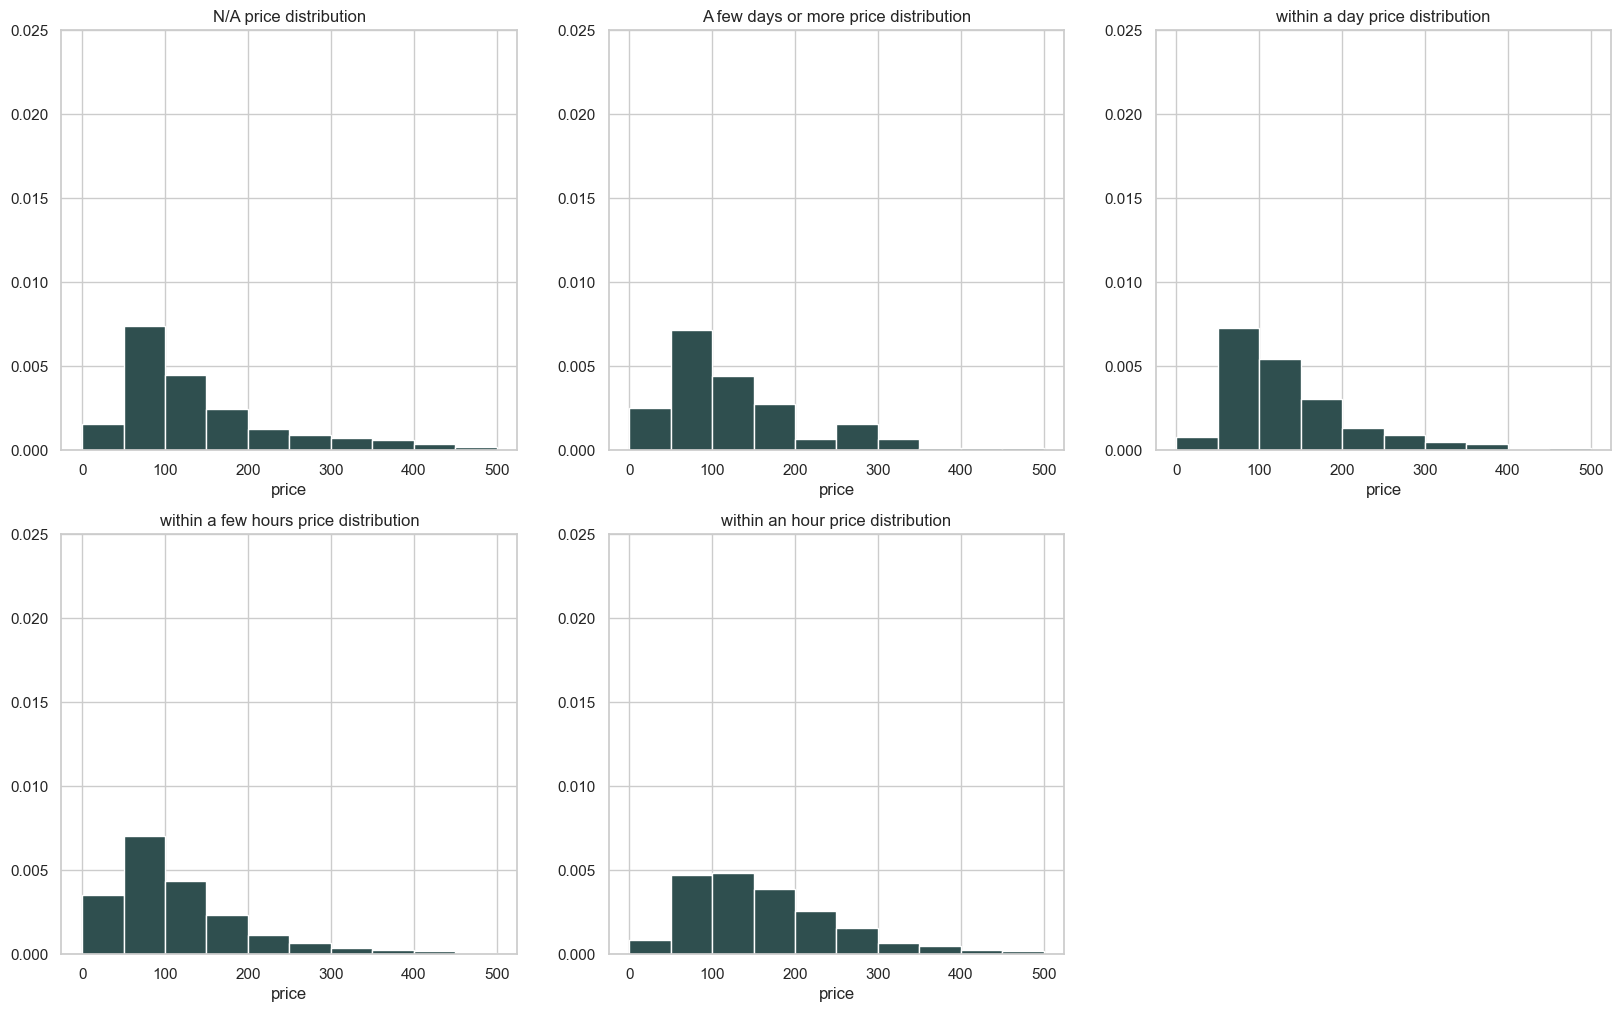

In [239]:
grouped = latest_listings_below_500.groupby("host_response_time")

figure = plt.figure(figsize=(20, 12))

axes = figure.add_subplot(2, 3, 1)
axes.hist(grouped["price"].get_group("N/A"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("N/A price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(2, 3, 2)
axes.hist(grouped["price"].get_group("a few days or more"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("A few days or more price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(2, 3, 3)
axes.hist(grouped["price"].get_group("within a day"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("within a day price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(2, 3, 4)
axes.hist(grouped["price"].get_group("within a few hours"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("within a few hours price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(2, 3, 5)
axes.hist(grouped["price"].get_group("within an hour"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("within an hour price distribution")
axes.set_xlabel("price")

plt.show()
plt.close()

Generally, the faster a host responds, the most expensive the AirBnB is nd the overall distribution of price is the same shape generally across all catogories.

## `host_response_rate` vs `price` <a id="host_respone_rate_vs_price"></a>

Similar to host response time, I expect host response rate has a positive correlation with rating which in turn gives the host leverage to raise the price of their listing.

In [241]:
latest_listings_below_500['host_response_rate'] = latest_listings_below_500['host_response_rate'].replace('N/A',np.NaN)
latest_listings_below_500['host_response_rate'] = latest_listings_below_500['host_response_rate'].replace('%', '', regex=True).astype(float)

In [242]:
latest_listings_below_500['host_response_rate'].isnull().values.any()

True

In [243]:
latest_listings_non_null_host_response_rate_below_500 = latest_listings_below_500[latest_listings_below_500["host_response_rate"].notnull()]

In [244]:
correlation(latest_listings_non_null_host_response_rate_below_500, "price", "host_response_rate")

Correlation coefficients:
r   = 0.07771063276548656 (very weak)
rho = 0.11987951077842735 (very weak)


The correlation is very weak but positive overall

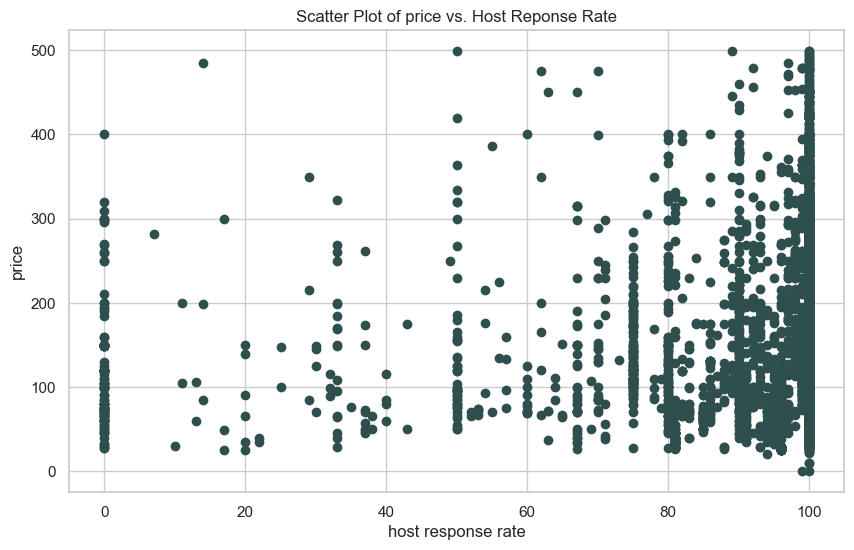

In [249]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_response_rate_below_500.host_response_rate, latest_listings_non_null_host_response_rate_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("host response rate")
axes.set_title("Scatter Plot of price vs. Host Reponse Rate")

plt.show()
plt.close()

The scatterplot shows this slight positive correlation. The handful of 0% response rate hosts might be skewing this distribution.

## `host_acceptance_rate` vs `price` <a id="host_acceptance_rate_vs_price"></a>

Similar to host response time and rate, I expect host acceptance rate has a positive correlation with rating which in turn gives the host leverage to raise the price of their listing.

In [250]:
latest_listings_below_500['host_acceptance_rate'] = latest_listings_below_500['host_acceptance_rate'].replace('N/A',np.NaN)
latest_listings_below_500['host_acceptance_rate'] = latest_listings_below_500['host_acceptance_rate'].replace('%', '', regex=True).astype(float)

In [251]:
latest_listings_below_500['host_response_rate'].isnull().values.any()

True

In [252]:
latest_listings_non_null_host_acceptance_rate_below_500 = latest_listings_below_500[latest_listings_below_500["host_acceptance_rate"].notnull()]

In [253]:
correlation(latest_listings_non_null_host_acceptance_rate_below_500, "price", "host_acceptance_rate")

Correlation coefficients:
r   = 0.14181600177900086 (very weak)
rho = 0.07371328158619253 (very weak)


The correlation is very weak but overall positive

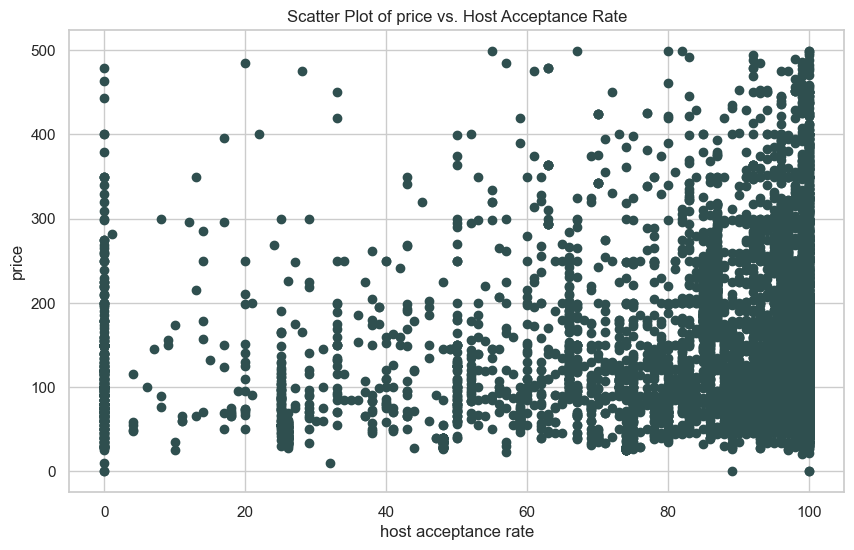

In [255]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_acceptance_rate_below_500.host_acceptance_rate, latest_listings_non_null_host_acceptance_rate_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("host acceptance rate")
axes.set_title("Scatter Plot of price vs. Host Acceptance Rate")

plt.show()
plt.close()

The scatterplot shows this slight positive correlation. The handful of 0% response rate hosts might be skewing this distribution.

## `host_is_superhost` vs `price` <a id="host_is_superhost_vs_price"></a>

A host being a superhost requires that they have many positive traits. This would certainly give the host leverage to raise the price of their AirBnB. I expect there to be a weak positive correlation between the host being a superhost and price.

In [256]:
latest_listings_below_500['host_is_superhost'].isnull().values.any()

True

In [257]:
latest_listings_non_null_host_is_superhost_below_500 = latest_listings_below_500[latest_listings_below_500["host_is_superhost"].notnull()]

In [258]:
describe_by_category(latest_listings_below_500, "price", "host_is_superhost", transpose=True)

host_is_superhost        False         True
count              7509.000000  2499.000000
mean                149.125982   146.375350
std                  92.025995    84.974677
min                   0.000000    28.000000
25%                  80.000000    89.000000
50%                 125.000000   124.000000
75%                 200.000000   175.000000
max                 499.000000   499.000000


There actually appears to be a very very weak negative correlation. The average price of listings hosted by superhosts is slightly less than the average price of listings hosted by non superhosts.

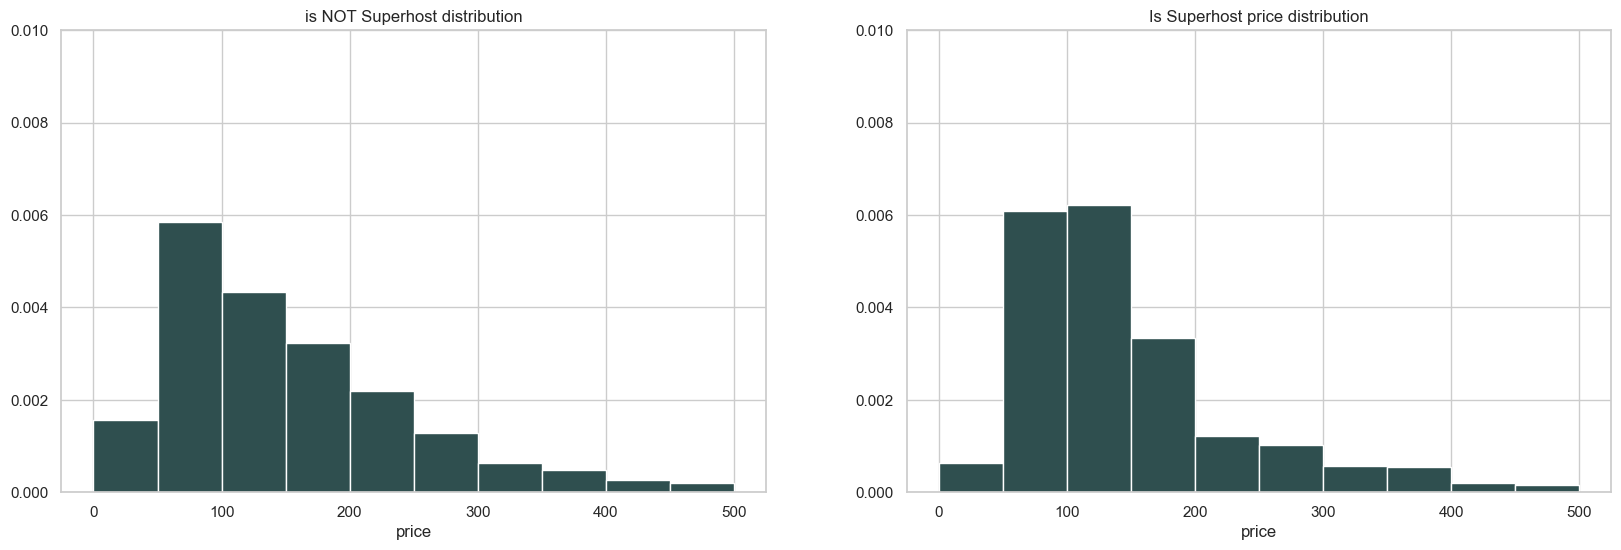

In [268]:
grouped = latest_listings_below_500.groupby("host_is_superhost")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["price"].get_group(False),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("is NOT Superhost distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["price"].get_group(True),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("Is Superhost price distribution")
axes.set_xlabel("price")

plt.show()
plt.close()

The overall distribution across the two categories is comparable. 

## `host_listings_count` vs `price` <a id="host_listings_count_vs_price"></a>

Host listings count has some potential plausible interactions with listing price. For one, hosts with multiple listings might be more real-estate savvy and know how to prep a home that is worth a higher nightly cost. Or these hosts might only  be able to afford multiple listings because they are all cheap real-estate which would mean these two variables have a negative correlation. 

In [277]:
latest_listings_below_500['host_listings_count'].isnull().values.any()

True

In [278]:
latest_listings_non_null_host_listings_count_below_500 = latest_listings_below_500[latest_listings_below_500["host_listings_count"].notnull()]

In [279]:
correlation(latest_listings_non_null_host_listings_count_below_500 , "price", "host_listings_count")

Correlation coefficients:
r   = 0.14389749392647586 (very weak)
rho = 0.14816794097130107 (very weak)


There is a positive correlation between these two variables. Hosts with more listings are more likely to have pricer AirBnBs.

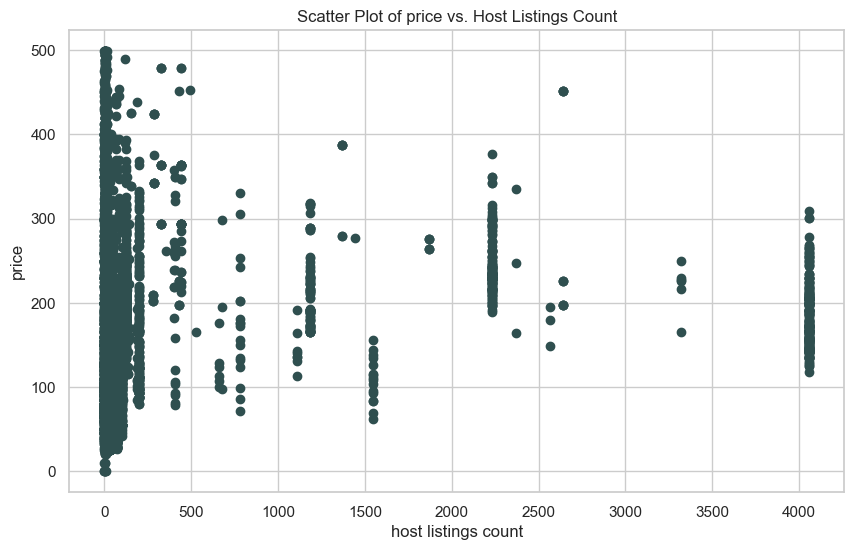

In [280]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_listings_count_below_500.host_listings_count, latest_listings_non_null_host_listings_count_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("host listings count")
axes.set_title("Scatter Plot of price vs. Host Listings Count")

plt.show()
plt.close()

This scatterplot is a bit hard to read because of the outlying host counts at 4000+ listings. We can't really see a positive correlation. Let's zoom in to hosts with 0-20 listings.

In [281]:
latest_listings_below_500['host_listings_count_under_20'] = latest_listings_below_500.host_listings_count[latest_listings_below_500.host_listings_count < 20]

In [282]:
latest_listings_non_null_host_listings_under_20_count_below_500 = latest_listings_below_500[latest_listings_below_500["host_listings_count_under_20"].notnull()]

In [284]:
correlation(latest_listings_non_null_host_listings_under_20_count_below_500 , "price", "host_listings_count_under_20")

Correlation coefficients:
r   = 0.03678169211730996 (very weak)
rho = -0.010678801308667132 (very weak)


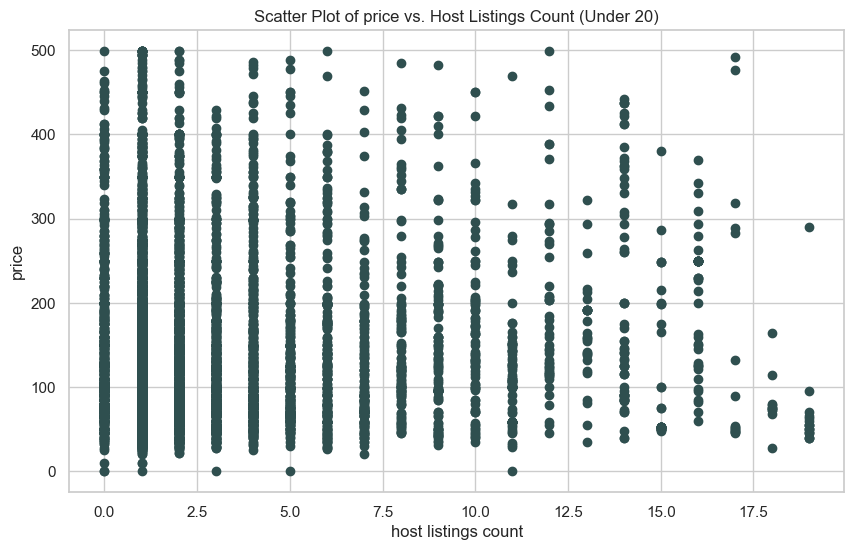

In [286]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_listings_under_20_count_below_500.host_listings_count_under_20, latest_listings_non_null_host_listings_under_20_count_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("host listings count")
axes.set_title("Scatter Plot of price vs. Host Listings Count (Under 20)")

plt.show()
plt.close()

The scarcity of hosts with more than 5 listings is making this distribution almost appear to be trending downward. However, knowing that most data points exist between 0 and 2.5 listings we see that there is a slight positive correlation.

## `host_has_profile_pic` vs `price` <a id="host_has_profile_pic_vs_price"></a>

Hosts are required to have a profile picture. The hosts that don't likely have junk and/or null data. Regardless, hosts with profile pictures could be interpreted as more trustable than hosts without because of the personal element and identity verification element thus I expect a slight positive correlation.

In [287]:
describe_by_category(latest_listings_below_500, "price", "host_has_profile_pic", transpose=True)

host_has_profile_pic       False         True
count                  69.000000  9786.000000
mean                  142.130435   148.837114
std                    97.503380    90.770977
min                     0.000000     0.000000
25%                    80.000000    82.000000
50%                   107.000000   125.000000
75%                   161.000000   196.000000
max                   499.000000   499.000000


There is a ~6 USD difference in mean listing price favoring hosts with a profile picture.

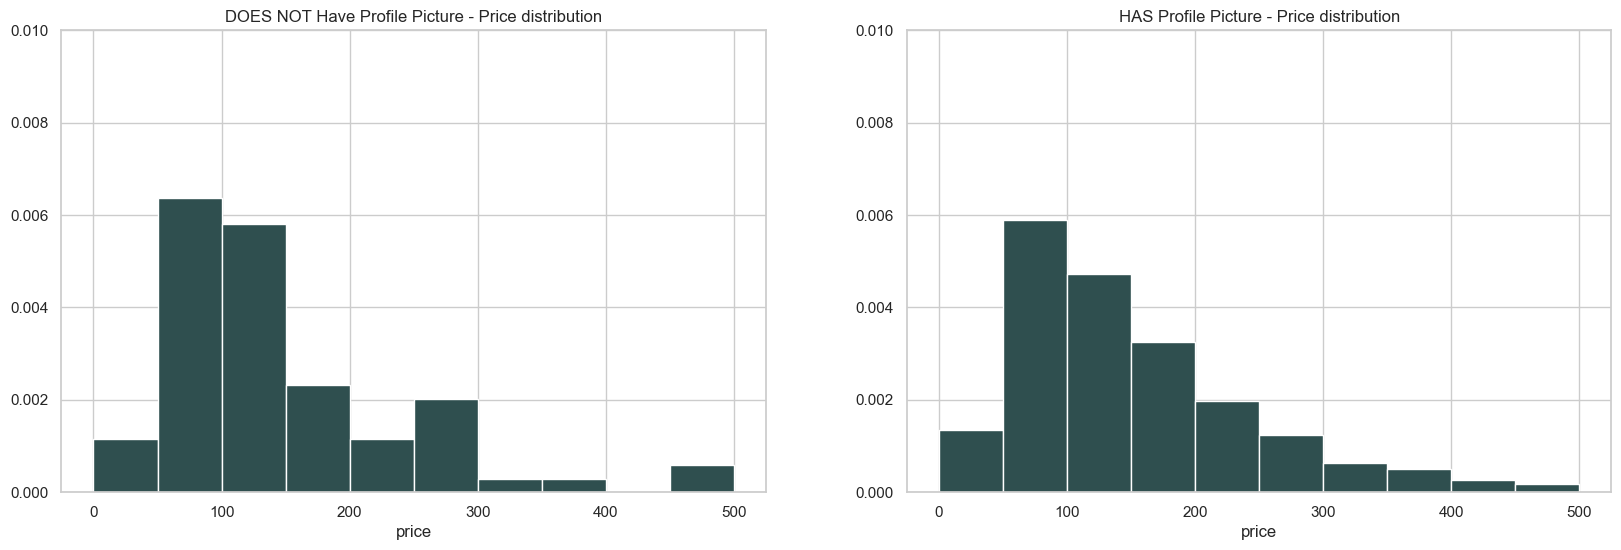

In [288]:
grouped = latest_listings_below_500.groupby("host_has_profile_pic")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["price"].get_group(False),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("DOES NOT Have Profile Picture - Price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["price"].get_group(True),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("HAS Profile Picture - Price distribution")
axes.set_xlabel("price")

plt.show()
plt.close()

The two groups have similar distributions. There are much fewer host without a profile picture so the distribution looks a bit rougher.

## `host_identity_verified` vs `price` <a id="host_identity_verified_vs_price"></a>

Hosts having their identity verified could be perceived as more trustable and therefore customers might feel more inclined to give them money and they have leverage to increase the price of their listings. For that reason, I expect the correlation to be weak and positive.

In [383]:
describe_by_category(latest_listings_below_500, "price", "host_identity_verified", transpose=True)

host_identity_verified        False         True
count                   1577.000000  8278.000000
mean                     141.034876   150.267577
std                       91.445010    90.626311
min                        0.000000     0.000000
25%                       78.000000    84.000000
50%                      111.000000   126.000000
75%                      179.000000   198.000000
max                      499.000000   499.000000


As expected, the distribution is weak but positive.

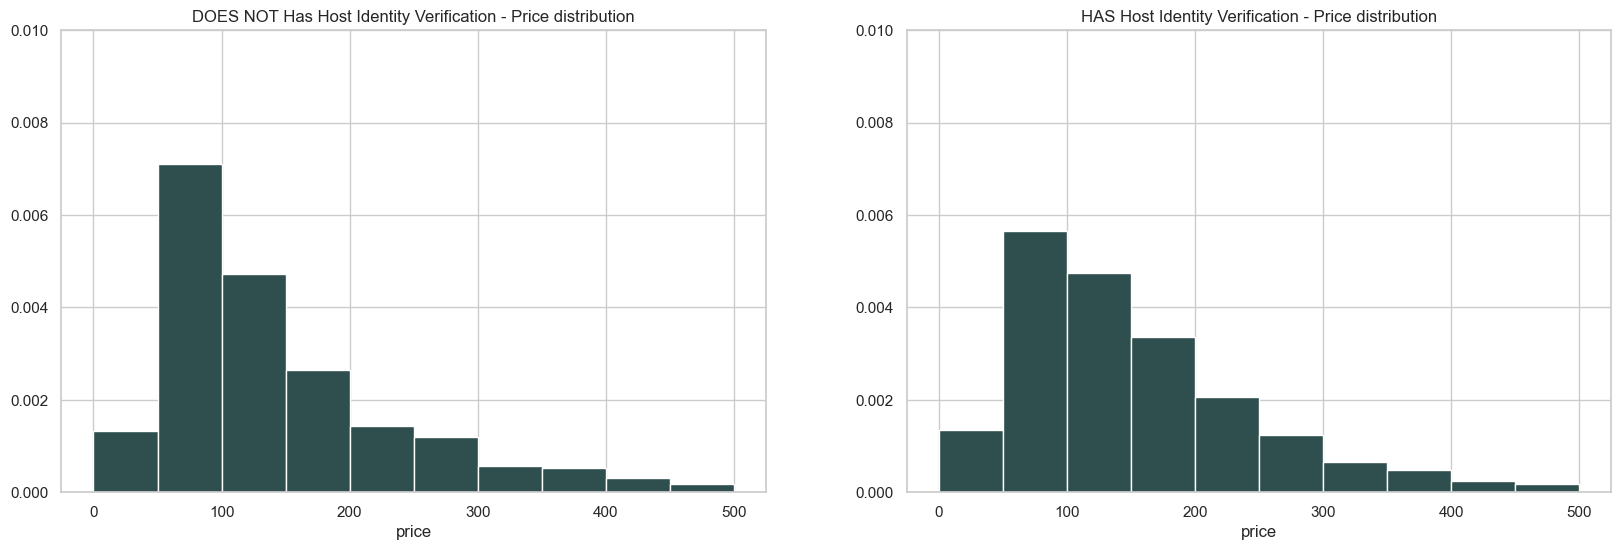

In [289]:
grouped = latest_listings_below_500.groupby("host_identity_verified")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["price"].get_group(False),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("DOES NOT Has Host Identity Verification - Price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["price"].get_group(True),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("HAS Host Identity Verification - Price distribution")
axes.set_xlabel("price")

plt.show()
plt.close()

The distributions for both are unimodal and skewed to the right - both hosts with and without identity verification look very similar in distribution of price.

# Close Connection

In [52]:
con.close()